In [77]:
import sys
import networkx as nx
import numpy as np
import random
from collections import defaultdict
import torch
import math
import importlib
import pandas as pd
#torch.set_num_threads(1)
import seaborn as sns

sys.path.insert(0, '../../')
import python_lib.graph_gen as graph_gen
import python_lib.models as models
#from python_lib import solvers

import glob

In [78]:
%matplotlib inline

In [79]:
def file_name(args, net=False):
    if net:
        return args.save_dir + "nets/" + f"N{args.N}_seed{args.seed}_model{args.model}_net_spec{args.net_spec}_J{args.J:.2}_h{args.h:.2}_lr{args.lr:.2}_max_step{args.max_step}_batch_size{args.batch_size}_std_fe_limit{args.std_fe_limit:.2}_beta{beta:.2f}.pt"
    else:
        return args.save_dir + f"N{args.N}_seed{args.seed}_model{args.model}_net_spec{args.net_spec}"



In [80]:
class names_params():
    def __init__(self):
        pass
all_nets = {}
args = names_params()
args.N = 100
args.model = "SK"
args.J = 1.
args.h = 0.
args.lr = 0.001
args.max_step = 1000
args.batch_size = 2000
args.std_fe_limit = 0.0001
args.save_dir = "new_data/"
args.batch_iter=20
seeds=[1]

beta_init = 0.1
beta_end=2
beta_step=39


In [81]:
net_specs = [ "SK_0rsb", "SK_1rsb","SK_2rsb", "SL", "MADE_21", "MADE_22"]
data_saved=pd.DataFrame()
Ns=[args.N]
data_dir="new_data/"
files = glob.glob(data_dir+"*.gzip")
#print(files)
for seed in seeds:
    for N in Ns:
        for net_spec in net_specs:
            name_f = f"N{N}_seed{seed}_model{args.model}_net_spec{net_spec}"
            res = [i for i in files if name_f in i]
            if len(res) == 1:
                def repl(name_col):
                    return name_col.replace(net_spec, "")
                df_ = pd.read_pickle(res[0])
                df_ = df_.rename(repl, axis='columns')
                data_saved = pd.concat([data_saved, df_], ignore_index=True)
                print(f"read: {res[0]}")
            elif len(res) > 1:
                print(res)
                def repl(name_col):
                    return name_col.replace(net_spec, "")
                df_ = pd.read_pickle(res[0])
                df_ = df_.rename(repl, axis='columns')
                data_saved = pd.concat([data_saved, df_], ignore_index=True)
                print(f"read: {res[0]}")

read: new_data/N100_seed1_modelSK_net_specSK_0rsb_20221221_004152.gzip
read: new_data/N100_seed1_modelSK_net_specSK_1rsb_20221221_035827.gzip
read: new_data/N100_seed1_modelSK_net_specSK_2rsb_20221221_070718.gzip
read: new_data/N100_seed1_modelSK_net_specSL_20221220_191034.gzip
read: new_data/N100_seed1_modelSK_net_specMADE_21_20221220_200553.gzip
read: new_data/N100_seed1_modelSK_net_specMADE_22_20221220_210132.gzip


In [82]:

net_specs = [ "SK_0rsb", "SK_1rsb","SK_2rsb"]
data = []
seed_wrong=2
for seed in [1]:
    for net_spec in net_specs:
        for beta in np.linspace(beta_init, beta_end, beta_step):
            print(seed, net_spec, beta)
            print()
            args.beta = beta
            args.seed = seed
            args.net_spec = net_spec
            net_beta = torch.load(file_name(args, net=True))
            net_beta.set_params_exact(net_beta.model, beta)
            stats = net_beta.compute_stats(beta, batch_size=args.batch_size, print_=True, batch_iter=args.batch_iter)
            stats["seed"] = seed
            stats["net_spec"] = net_spec
            stats["beta"] = beta
            data.append(stats)
            
            print()
            print("wrong")
            args.seed = seed_wrong
            net_beta_wrong = torch.load(file_name(args, net=True))
            net_beta_wrong.set_params_exact(net_beta_wrong.model, beta)
            net_beta_wrong.model = net_beta.model
            stats = net_beta_wrong.compute_stats(beta, batch_size=args.batch_size, print_=True, batch_iter=args.batch_iter)
            stats["seed"] = seed
            stats["net_spec"] = net_spec + "_wrong"
            stats["beta"] = beta
            data.append(stats)

            print()
            print("tranf_learn")
            args.seed = seed_wrong
            net_beta_wrong = torch.load(file_name(args, net=True))
            net_beta_wrong.set_params_exact(net_beta.model, beta)
            net_beta_wrong.model = net_beta.model
            stats = net_beta_wrong.compute_stats(beta, batch_size=args.batch_size, print_=True, batch_iter=args.batch_iter)
            stats["seed"] = seed
            stats["net_spec"] = net_spec + "_tf"
            stats["beta"] = beta
            data.append(stats)
            
            print()
            print("tranf_learn_plus")
            args.seed = seed_wrong
            net_beta_wrong = torch.load(file_name(args, net=True))
            net_beta_wrong.set_params_exact(net_beta.model, beta)
            net_beta_wrong.model = net_beta.model
            net_beta_wrong.train(lr=1e-3,
                                opt="adam",
                                beta=beta,
                                max_step=100,
                                batch_size=2000,
                                std_fe_limit=1e-4,
                                batch_iter=1,)
            stats = net_beta_wrong.compute_stats(beta, batch_size=args.batch_size, print_=True, batch_iter=args.batch_iter)
            stats["seed"] = seed
            stats["net_spec"] = net_spec + "_tf_plus"
            stats["beta"] = beta
            data.append(stats)

net_specs = [ "SK_0rsb", "SK_1rsb","SK_2rsb", "SL", "MADE_21", "MADE_22"]


1 SK_0rsb 0.1

step: 0 0.10000 fe: -6.956 +- 0.00142 E: -0.049, S: 0.691, M: 0.0808 stats : 0.0097
wrong
step: 0 0.10000 fe: -6.908 +- 0.10026 E: 0.000, S: 0.691, M: 0.077 stats : 0.010126
tranf_learn
step: 0 0.10000 fe: -6.956 +- 0.00607 E: -0.048, S: 0.691, M: 0.0794 stats : 0.0096
tranf_learn_plus
step: 2 0.10000 fe: -6.955 +- 0.01167 E: -0.049, S: 0.691, M: 0.0808 sample_t : 0.15 log_prob : 0.12 loss : 0.00025 optimizer : 0.11 stats : 0.012

KeyboardInterrupt: 

In [ ]:
data = pd.DataFrame(data)

<AxesSubplot:xlabel='beta', ylabel='free_energy_std'>

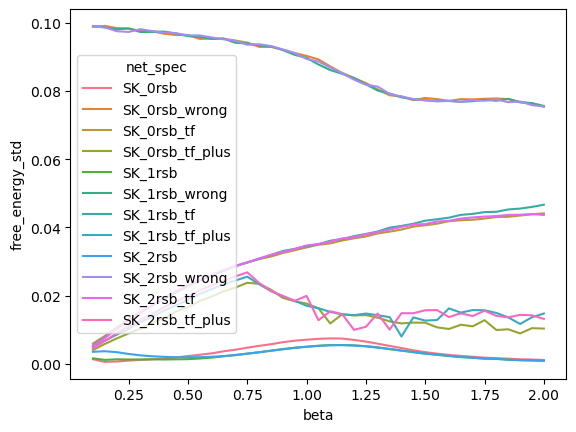

In [ ]:
sns.lineplot(data=data, x="beta", y="free_energy_std", hue="net_spec")

[(-0.76, -0.6999)]

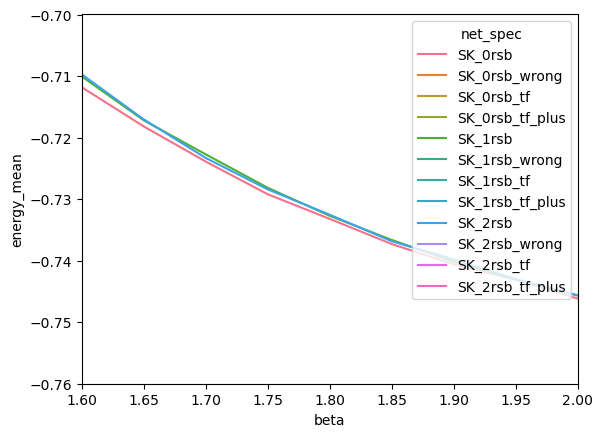

In [ ]:
g = sns.lineplot(data=data, x="beta", y="energy_mean", hue="net_spec")
g.set(xlim=(1.6, 2))
g.set(ylim=(-0.76, -0.6999))

<AxesSubplot:xlabel='beta', ylabel='free_energy_std'>

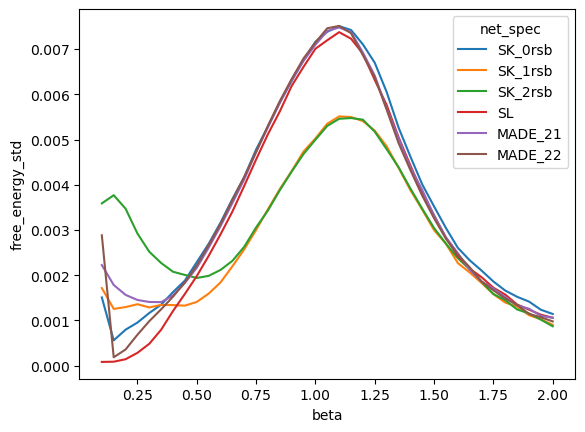

In [ ]:
sns.lineplot(data=data_saved, x="beta", y="free_energy_std", hue="net_spec")

In [ ]:
y

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
112   NaN
113   NaN
114   NaN
115   NaN
116   NaN
Name: free_energy_mean, Length: 78, dtype: float64

In [ ]:
x

0     0.10
1     0.15
2     0.20
3     0.25
4     0.30
5     0.35
6     0.40
7     0.45
8     0.50
9     0.55
10    0.60
11    0.65
12    0.70
13    0.75
14    0.80
15    0.85
16    0.90
17    0.95
18    1.00
19    1.05
20    1.10
21    1.15
22    1.20
23    1.25
24    1.30
25    1.35
26    1.40
27    1.45
28    1.50
29    1.55
30    1.60
31    1.65
32    1.70
33    1.75
34    1.80
35    1.85
36    1.90
37    1.95
38    2.00
Name: beta, dtype: float64

In [ ]:
type(data_saved[data_saved.net_spec=="SK_2rsb"].free_energy_mean)

pandas.core.series.Series

In [ ]:
data_saved[data_saved.net_spec==nn].free_energy_mean.to_numpy() - data_saved[data_saved.net_spec=="SK_2rsb"].free_energy_mean.to_numpy()

array([-3.22723389e-05, -1.08998617e-04, -9.15336609e-05, -8.32214355e-05,
       -9.73765055e-05, -4.19507708e-05, -1.08718872e-05, -2.00992160e-05,
        4.47921753e-05,  5.74077259e-05,  1.72106425e-04,  2.63278668e-04,
        3.71360779e-04,  5.15335083e-04,  6.54892921e-04,  7.78934254e-04,
        8.96347894e-04,  1.12452457e-03,  1.23959732e-03,  1.33926028e-03,
        1.40180068e-03,  1.45981498e-03,  1.42753919e-03,  1.27399292e-03,
        1.09724192e-03,  9.25849632e-04,  7.30182103e-04,  5.75574678e-04,
        4.84240214e-04,  3.64852413e-04,  2.96049118e-04,  2.19967004e-04,
        1.85699463e-04,  1.59611293e-04,  1.34908888e-04,  1.11941776e-04,
        9.84954834e-05,  7.80741374e-05,  8.95195007e-05])

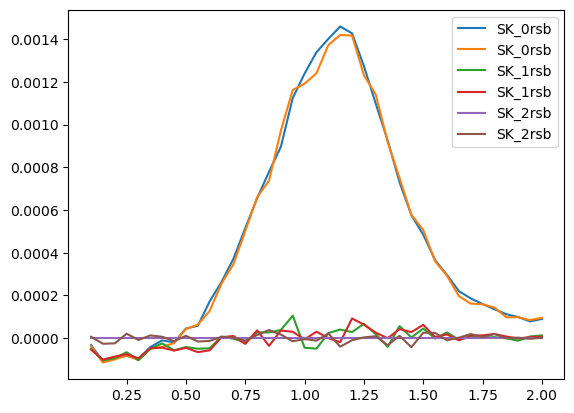

In [ ]:
import matplotlib.pyplot as plt

net_specs = [ "SK_0rsb", "SK_1rsb","SK_2rsb"]
for nn in net_specs:
    x = data_saved[data_saved.net_spec==nn].beta
    y = data_saved[data_saved.net_spec==nn].free_energy_mean.to_numpy() - data_saved[data_saved.net_spec=="SK_2rsb"].free_energy_mean.to_numpy()
    plt.plot(x,y, label=nn)
    
    x = data[data.net_spec==nn].beta
    y = data[data.net_spec==nn].free_energy_mean.to_numpy() - data_saved[data_saved.net_spec=="SK_2rsb"].free_energy_mean.to_numpy()
    plt.plot(x,y, label=nn)
plt.legend()

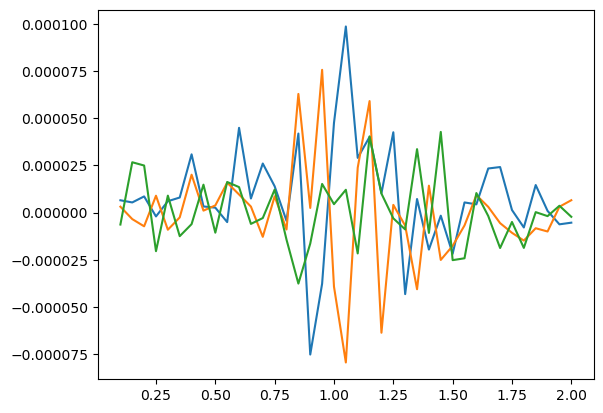

In [ ]:
import matplotlib.pyplot as plt

net_specs = [ "SK_0rsb", "SK_1rsb","SK_2rsb"]
for nn in net_specs:
    x = data_saved[data_saved.net_spec==nn].beta
    y = data_saved[data_saved.net_spec==nn].free_energy_mean - data[data.net_spec==nn].free_energy_mean
    plt.plot(x,y, label=nn)

In [ ]:
data.dtypes

beta                float64
free_energy_mean    float64
free_energy_std     float64
entropy_mean        float64
energy_mean         float64
mag                 float32
mag_mean            float64
q                    object
seed                  int64
net_spec             object
dtype: object

In [86]:

net_specs = ["SK_2rsb"]
seed_wrong=2
for seed in [1]:
    for net_spec in net_specs:
        for beta in np.linspace(1.6, beta_end, beta_step):
            print(seed, net_spec, beta)
            print()
            args.beta = beta
            args.seed = seed
            args.net_spec = net_spec
            net_beta = torch.load(file_name(args, net=True))
            net_beta.set_params_exact(net_beta.model, beta)
            stats = net_beta.compute_stats(beta, batch_size=args.batch_size, print_=True, batch_iter=args.batch_iter)
            stats["seed"] = seed
            stats["net_spec"] = net_spec
            stats["beta"] = beta
            
            print()
            print("wrong")
            args.seed = seed_wrong
            net_beta_wrong = torch.load(file_name(args, net=True))
            net_beta_wrong.set_params_exact(net_beta_wrong.model, beta)
            net_beta_wrong.model = net_beta.model
            stats = net_beta_wrong.compute_stats(beta, batch_size=args.batch_size, print_=True, batch_iter=args.batch_iter)
            stats["seed"] = seed
            stats["net_spec"] = net_spec + "_wrong"
            stats["beta"] = beta

            print()
            print("tranf_learn")
            args.seed = seed_wrong
            net_beta_wrong = torch.load(file_name(args, net=True))
            net_beta_wrong.set_params_exact(net_beta.model, beta)
            net_beta_wrong.model = net_beta.model
            stats = net_beta_wrong.compute_stats(beta, batch_size=args.batch_size, print_=True, batch_iter=args.batch_iter)
            stats["seed"] = seed
            stats["net_spec"] = net_spec + "_tf"
            stats["beta"] = beta
            print()
            print("tranf_learn_init")
            args.seed = seed_wrong
            args.beta = beta
            net_beta_wrong = torch.load(file_name(args, net=True))
            net_beta_wrong.set_params_exact(net_beta.model, beta)
            net_beta_wrong.model = net_beta.model
            net_beta_wrong.train(lr=1e-3,
                                opt="adam",
                                beta=beta,
                                max_step=1000,
                                batch_size=2000,
                                std_fe_limit=1e-4,
                                batch_iter=1,)
            stats = net_beta_wrong.compute_stats(beta, batch_size=args.batch_size, print_=True, batch_iter=args.batch_iter)
            stats["seed"] = seed
            stats["net_spec"] = net_spec + "_tf_plus"
            stats["beta"] = beta


            print()
            print("tranf_learn_plus")
            args.seed = seed_wrong
            net_beta_wrong = torch.load(file_name(args, net=True))
            net_beta_wrong.set_params_exact(net_beta.model, beta)
            net_beta_wrong.model = net_beta.model
            net_beta_wrong.train(lr=1e-3,
                                opt="adam",
                                beta=beta,
                                max_step=1000,
                                batch_size=2000,
                                std_fe_limit=1e-4,
                                batch_iter=1,)
            stats = net_beta_wrong.compute_stats(beta, batch_size=args.batch_size, print_=True, batch_iter=args.batch_iter)
            stats["seed"] = seed
            stats["net_spec"] = net_spec + "_tf_plus"
            stats["beta"] = beta

net_specs = [ "SK_0rsb", "SK_1rsb","SK_2rsb", "SL", "MADE_21", "MADE_22"]


1 SK_2rsb 1.6

step: 0 1.60000 fe: -0.821 +- 0.00243 E: -0.709, S: 0.179, M: 0.0915 stats : 0.0117
wrong
step: 0 1.60000 fe: -0.202 +- 0.07740 E: -0.023, S: 0.286, M: 0.0626 stats : 0.0099
tranf_learn
step: 0 1.60000 fe: -0.667 +- 0.04209 E: -0.399, S: 0.428, M: 0.0852 stats : 0.0091
tranf_learn_init
step: 0 1.60000 fe: -0.815 +- 0.00404 E: -0.720, S: 0.151, M: 0.097 stats : 0.011290.4 log_prob : 0.27 loss : 0.00032 optimizer : 0.27 stats : 0.0098
tranf_learn_plus
step: 0 1.60000 fe: -0.815 +- 0.00418 E: -0.720, S: 0.152, M: 0.0966 stats : 0.00951 SK_2rsb 1.61052631578947380.00033 optimizer : 0.27 stats : 0.013

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/ocadni/opt/anaconda3/envs/m1torch/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/jy/gjfds_4d4xsfqkq02klzlj240000gn/T/ipykernel_86514/448714802.py", line 11, in <cell line: 3>
    net_beta = torch.load(file_name(args, net=True))
  File "/Users/ocadni/opt/anaconda3/envs/m1torch/lib/python3.10/site-packages/torch/serialization.py", line 699, in load
    Args:
  File "/Users/ocadni/opt/anaconda3/envs/m1torch/lib/python3.10/site-packages/torch/serialization.py", line 230, in _open_file_like
    return getattr(module, storage_type.__name__.replace('Storage', 'Tensor'))
  File "/Users/ocadni/opt/anaconda3/envs/m1torch/lib/python3.10/site-packages/torch/serialization.py", line 211, in __init__
FileNotFoundError: [Errno 2] No such file or directory: 'new_data/nets/N100_seed1_modelSK_net_specSK_2rsb_J1.0_h0.0_lr0.001_max_step1000_bat

KeyError: 'mean_fe'

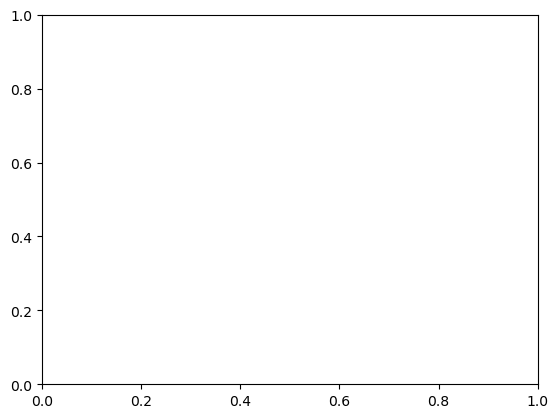

In [ ]:
data_saved.plot(x="beta", y="mean_fe", kind="scatter", c="seed", colormap="viridis")

In [ ]:
data['seed'] = data['seed'].astype('int')
data['N'] = data['N'].astype('int')
data['beta'] = data['beta'].astype('float')
data_exact['seed'] = data_exact['seed'].astype('int')
data_exact['N'] = data_exact['N'].astype('int')

In [ ]:
data["err_fe"] = 0
data["err_fe_rel"] = 0
for N in Ns:
    print(N)
    for seed in seeds:
        d_e = data_exact[(data_exact["N"] == N) & (data_exact["seed"] == seed)]
        d_ = data[(data["N"] == N) & (data["seed"] == seed)]
        to_set = []
        to_set_res = []

        for index, row in d_.iterrows():
            beta =  row["beta"]
            if len(d_e) > 0:
                fe_ex = d_e[np.abs(d_e["beta"]-beta)<1e-6]["free_energy_mean"].item()
            else:
                net_spec = "SL"
                fe_ex = d_[(np.abs(d_["beta"]-beta)<1e-6) & (d_["net_spec"]==net_spec)]["free_energy_mean"].item()
            vv = d_.loc[index]["free_energy_mean"].item() - fe_ex
            data.at[index, "err_fe"] = vv
            data.at[index, "err_fe_rel"] = vv / np.abs(fe_ex)
        #data_all[N] = data[N].copy()

20
50
100
200


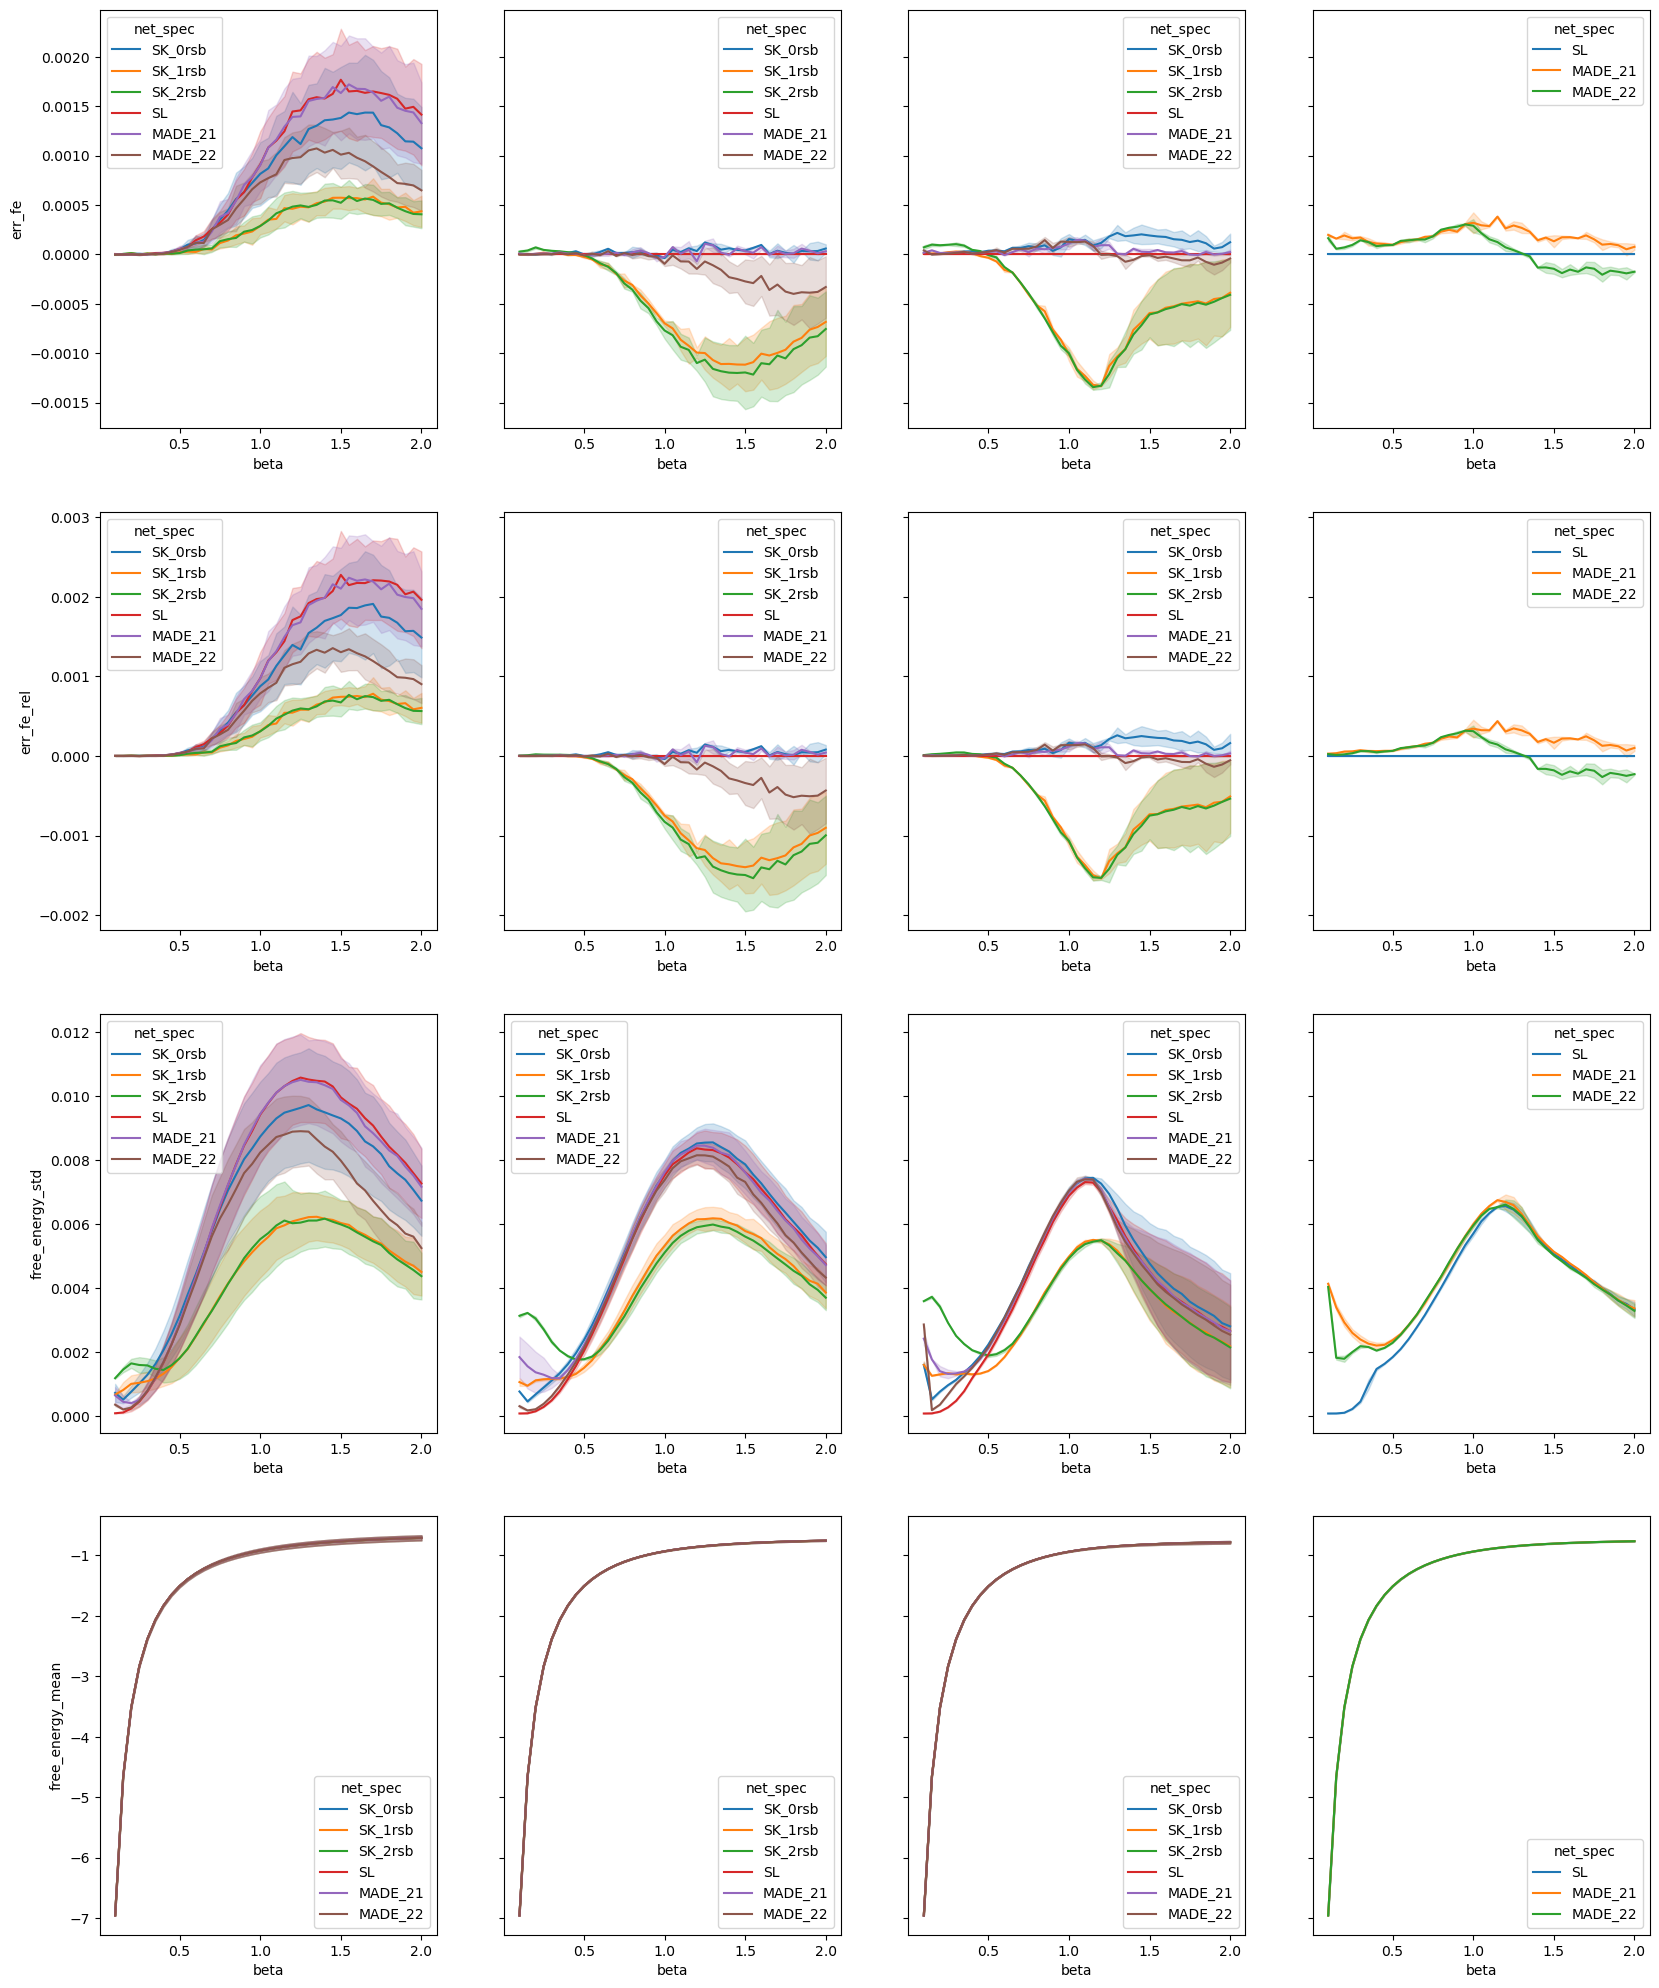

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

Ns=[20, 50, 100, 200]
fig, axs = plt.subplots(4,4, figsize=(20, 25), sharey="row")
# N=10
# #dd = data[N].rolling(5, on="beta").mean()
# sns.lineplot(data=data[N], x="beta", y="err_fe", hue="net_spec", ax=axs[0][0])
for i, N in enumerate(Ns):
    d_ = data[(data["N"] == N)]
    sns.lineplot(data=d_, x="beta", y="err_fe", hue="net_spec", ax=axs[0][i], legend="full")

# N=10
# sns.lineplot(data=data[N], x="beta", y="err_fe_rel", hue="net_spec", ax=axs[1][0])
for i, N in enumerate(Ns):
    d_ = data[(data["N"] == N)]
    sns.lineplot(data=d_, x="beta", y="err_fe_rel", hue="net_spec", ax=axs[1][i], legend="full")

# N=10
# sns.lineplot(data=data[N], x="beta", y="free_energy_std", hue="net_spec", ax=axs[2][0])
for i, N in enumerate(Ns):
    d_ = data[(data["N"] == N)]
    sns.lineplot(data=d_, x="beta", y="free_energy_std", hue="net_spec", ax=axs[2][i], legend="full")

for i, N in enumerate(Ns):
    d_ = data[(data["N"] == N)]
    sns.lineplot(data=d_, x="beta", y="free_energy_mean", hue="net_spec", ax=axs[3][i], legend="full")


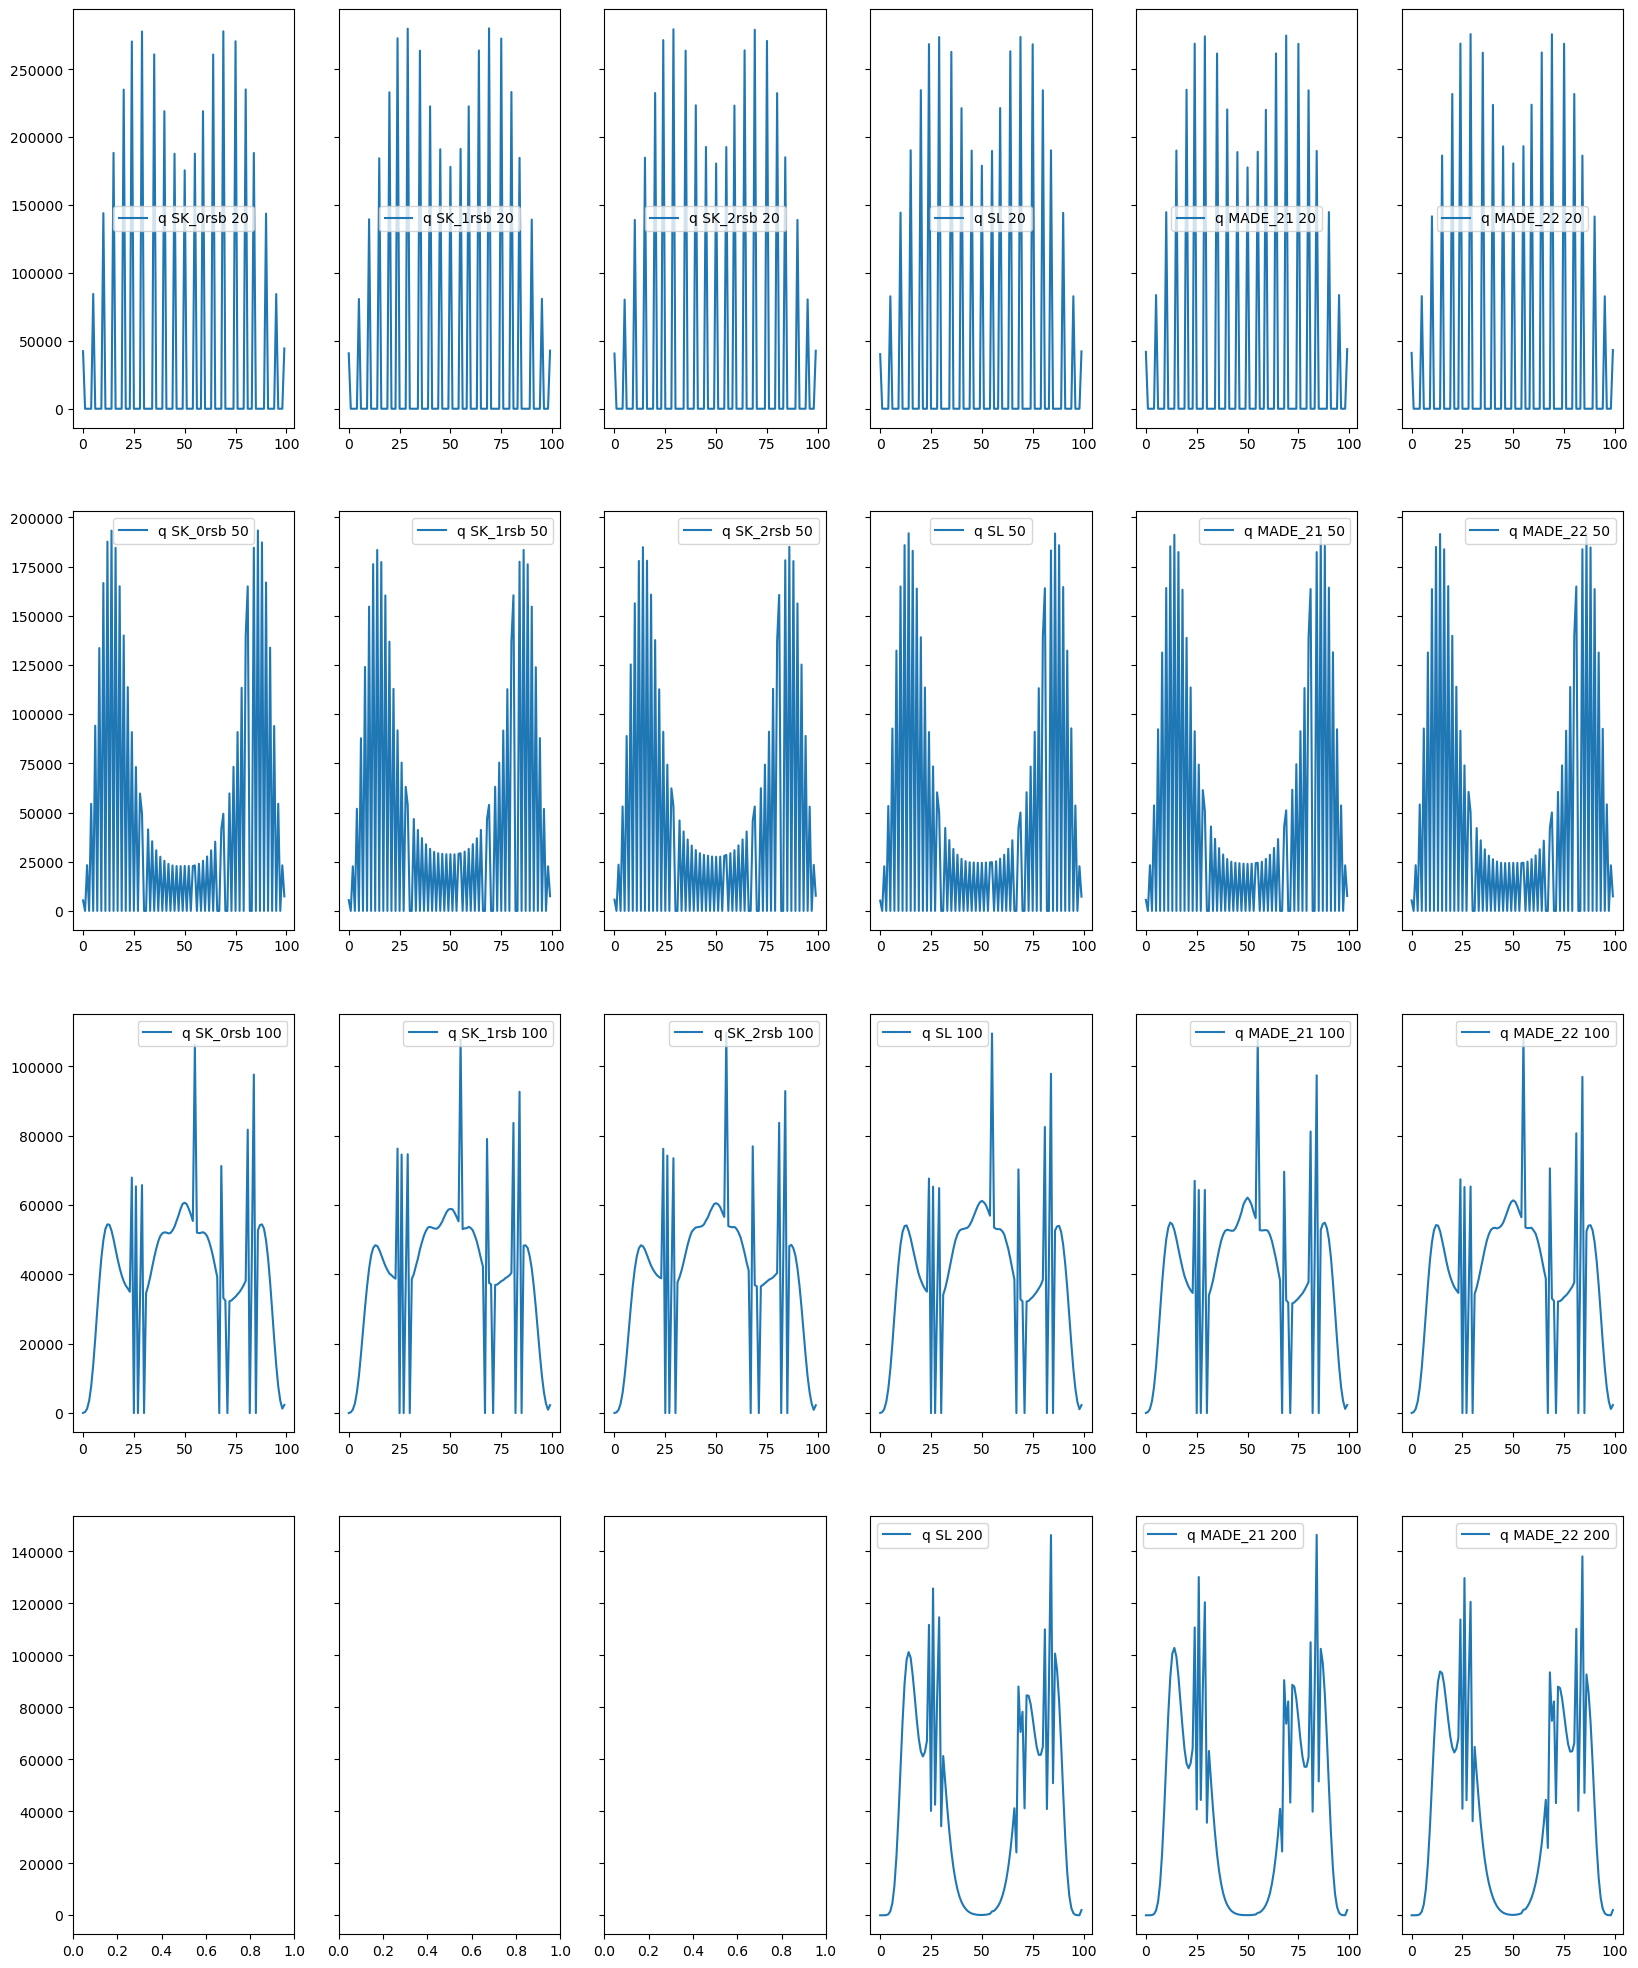

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

Ns=[20, 50, 100, 200]
fig, axs = plt.subplots(len(Ns),len(net_specs), figsize=(20, 25), sharey="row")
for i, N in enumerate(Ns):
    for ii, nn in enumerate(net_specs):
        beta=2
        d_ = data[(data["net_spec"] == nn) & (data["N"] == N) & (data["seed"] == 2) & (np.abs(data["beta"] - beta) < 1e-6)]
        #print(torch.tensor(d_["q"]))
        if len(d_) > 0:
            axs[i][ii].plot(d_["q"].item(), label=f"q {nn} {N}")
            axs[i][ii].legend()

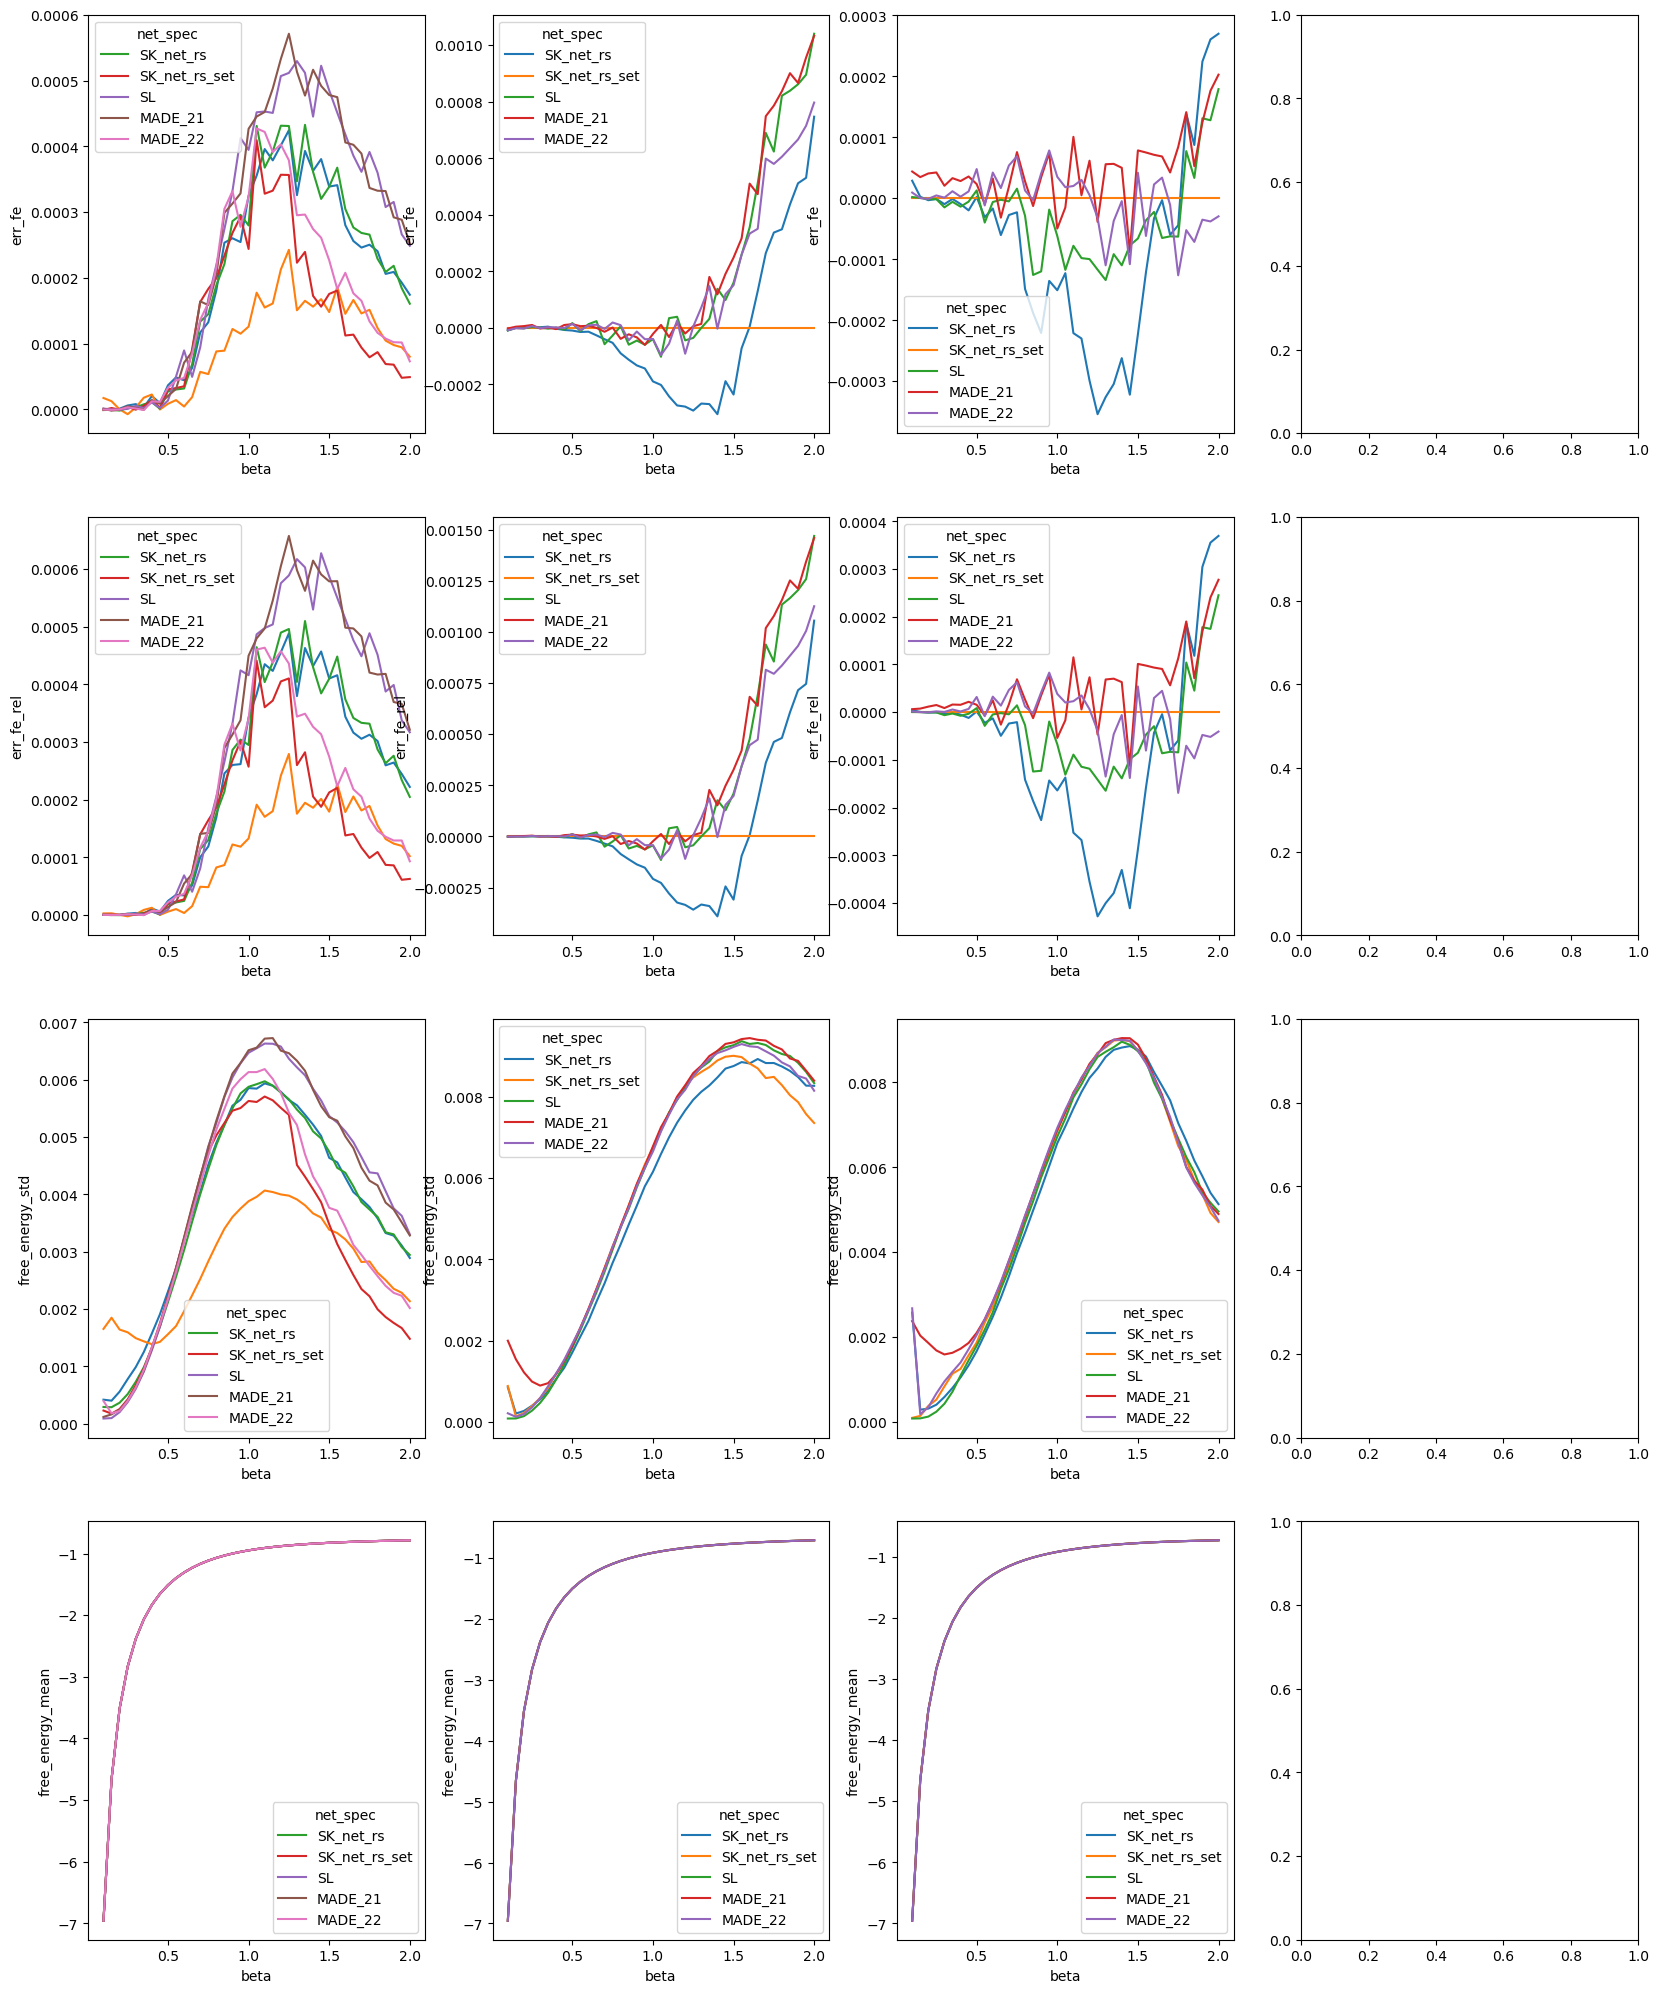

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

data_pl = {}
to_pl = [ "_SK_net_0rs", "_SK_net_1rs","SK_net_rs", "SK_net_rs_set",  "SL", "MADE_21", "MADE_22"]
for N in Ns:
    data_pl[N] = data[N][data[N]['net_spec'].isin(to_pl)]    

#fig, axs = plt.subplots(4,4, figsize=(20, 25), sharey="row")
fig, axs = plt.subplots(4,4, figsize=(20, 25))
# N=10
# #dd = data[N].rolling(5, on="beta").mean()
# sns.lineplot(data=data[N], x="beta", y="err_fe", hue="net_spec", ax=axs[0][0])
for i, N in enumerate(Ns):
    sns.lineplot(data=data_pl[N], x="beta", y="err_fe", hue="net_spec", ax=axs[0][i], legend="full")

# N=10
# sns.lineplot(data=data[N], x="beta", y="err_fe_rel", hue="net_spec", ax=axs[1][0])
for i, N in enumerate(Ns):
    sns.lineplot(data=data_pl[N], x="beta", y="err_fe_rel", hue="net_spec", ax=axs[1][i], legend="full")

# N=10
# sns.lineplot(data=data[N], x="beta", y="free_energy_std", hue="net_spec", ax=axs[2][0])
for i, N in enumerate(Ns):
    sns.lineplot(data=data_pl[N], x="beta", y="free_energy_std", hue="net_spec", ax=axs[2][i], legend="full")
for i, N in enumerate(Ns):
    sns.lineplot(data=data_pl[N], x="beta", y="free_energy_mean", hue="net_spec", ax=axs[3][i], legend="full")


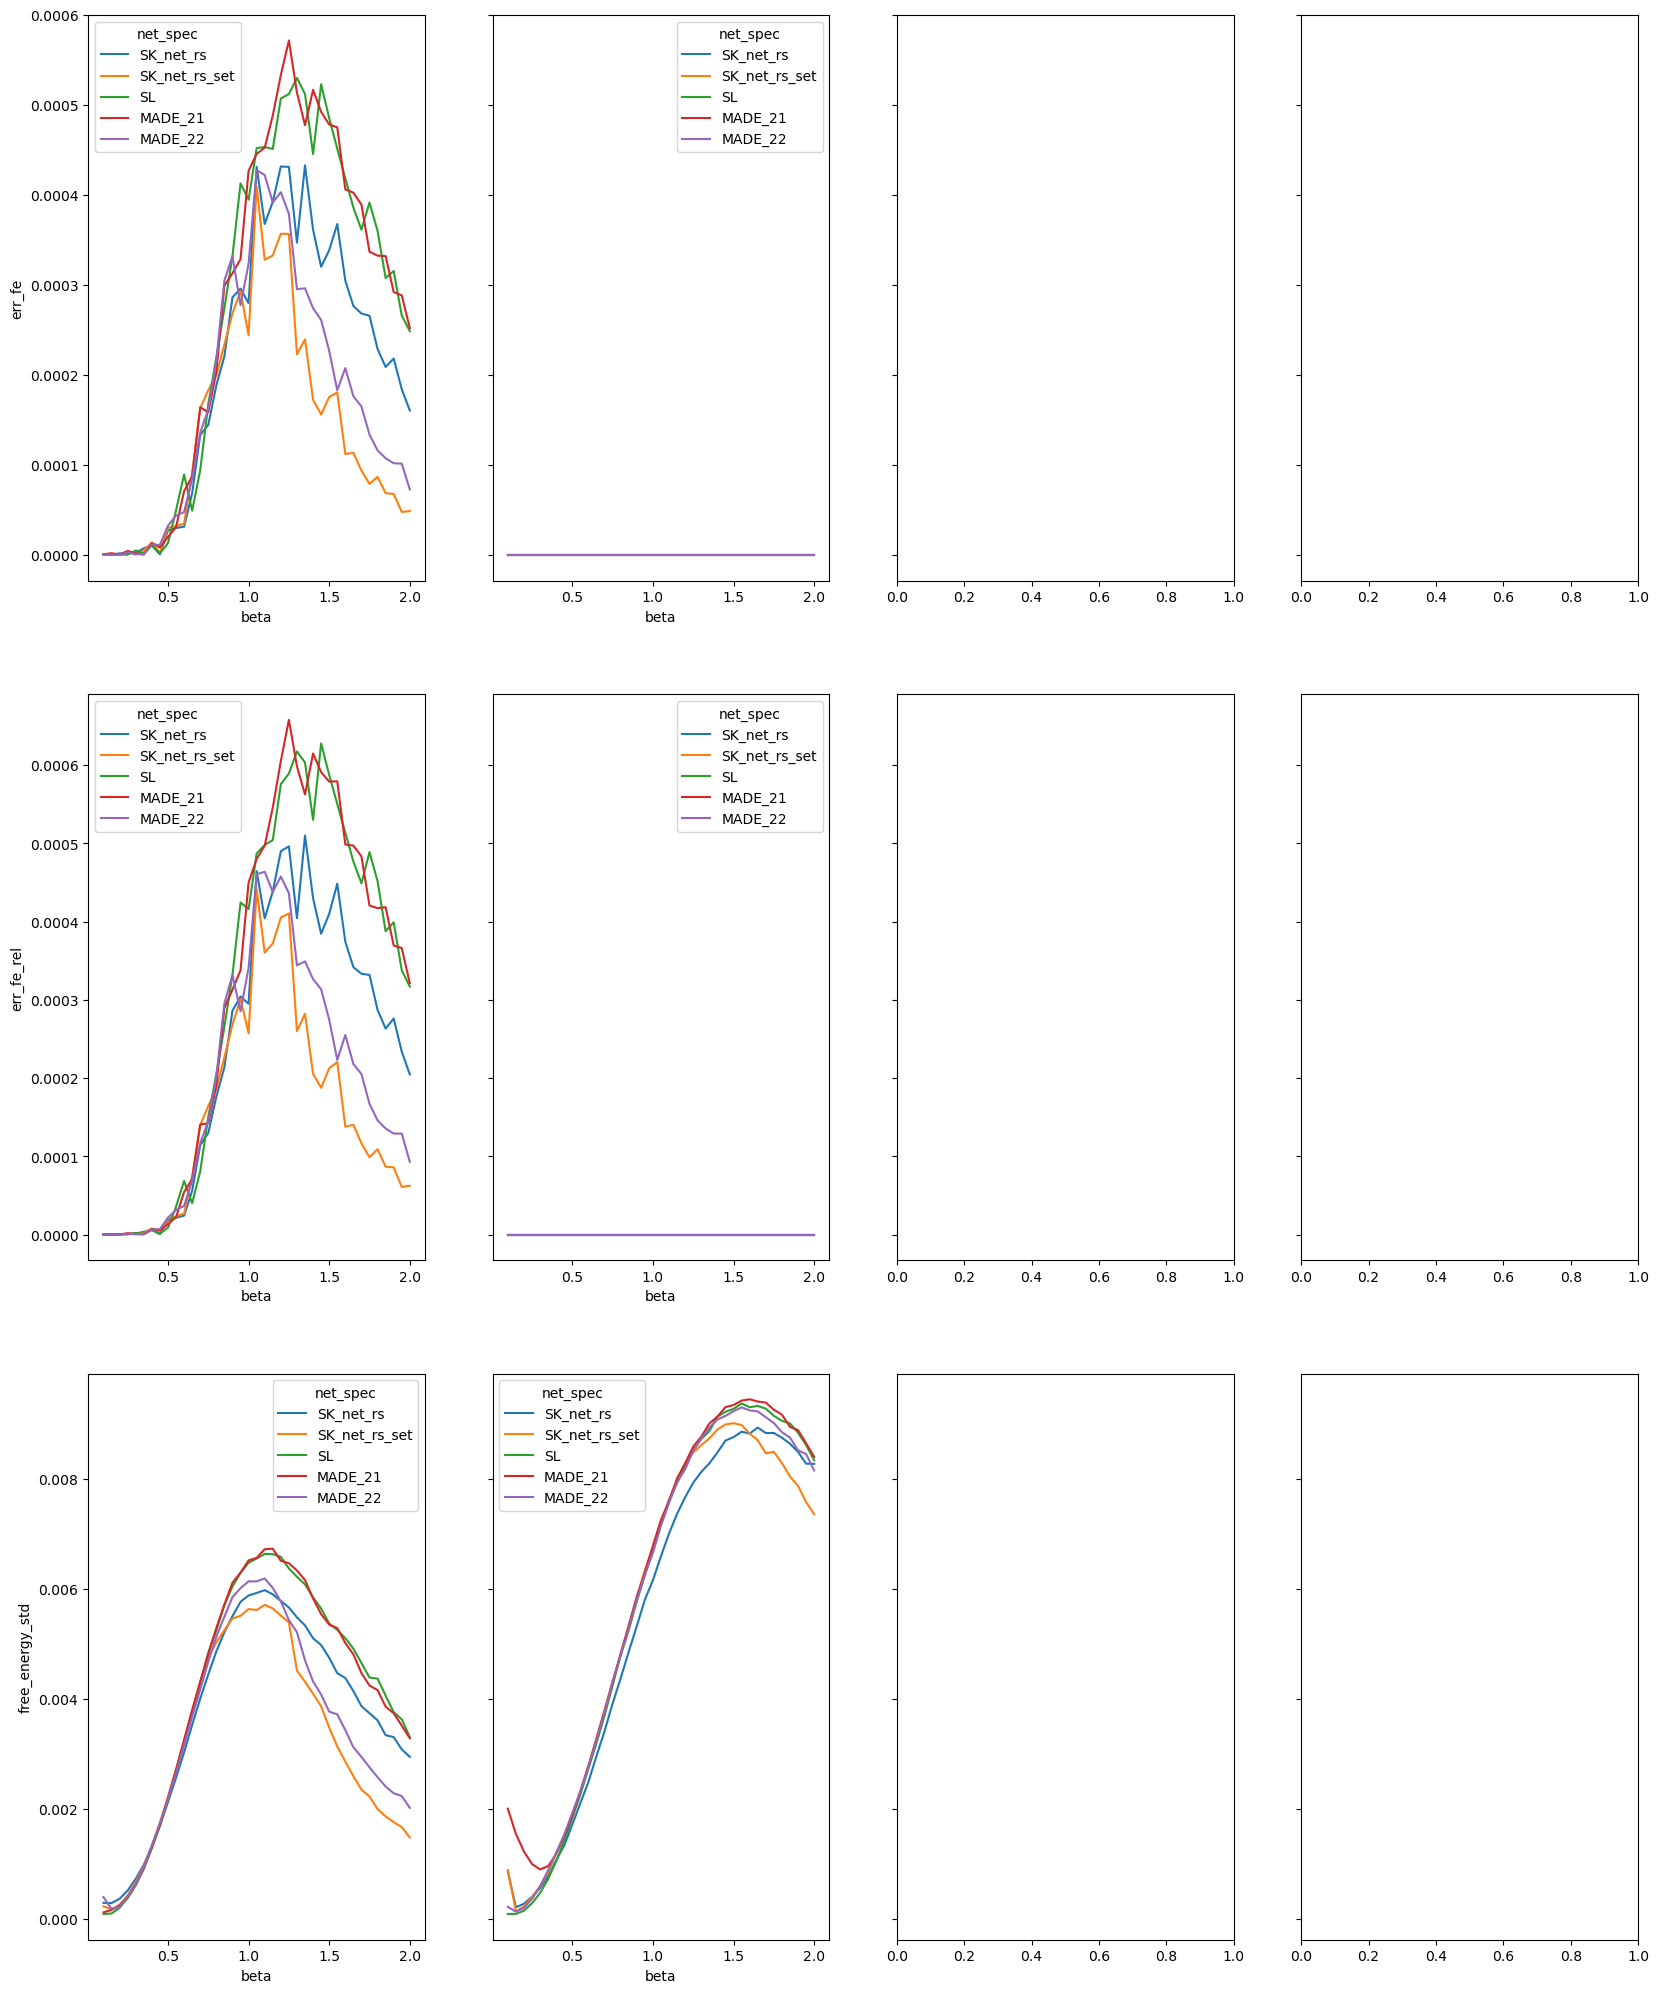

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

data_pl = {}
to_pl = [ "SK_net_rs", "SK_net_rs_set",  "SL", "MADE_21", "MADE_22"]
for N in Ns:
    data_pl[N] = data[N][data[N]['net_spec'].isin(to_pl)]    

fig, axs = plt.subplots(3,4, figsize=(20, 25), sharey="row")
# N=10
# #dd = data[N].rolling(5, on="beta").mean()
# sns.lineplot(data=data[N], x="beta", y="err_fe", hue="net_spec", ax=axs[0][0])
for i, N in enumerate(Ns):
    sns.lineplot(data=data_pl[N], x="beta", y="err_fe", hue="net_spec", ax=axs[0][i])

# N=10
# sns.lineplot(data=data[N], x="beta", y="err_fe_rel", hue="net_spec", ax=axs[1][0])
for i, N in enumerate(Ns):
    sns.lineplot(data=data_pl[N], x="beta", y="err_fe_rel", hue="net_spec", ax=axs[1][i])

# N=10
# sns.lineplot(data=data[N], x="beta", y="free_energy_std", hue="net_spec", ax=axs[2][0])
for i, N in enumerate(Ns):
    sns.lineplot(data=data_pl[N], x="beta", y="free_energy_std", hue="net_spec", ax=axs[2][i])


In [ ]:
data_pl[20]["num_train_params"]

39      20.0
40      20.0
41      20.0
42      20.0
43      20.0
       ...  
346    420.0
347    420.0
348    420.0
349    420.0
350    420.0
Name: num_train_params, Length: 273, dtype: float64

In [ ]:
all_N = pd.DataFrame()
all_N = pd.concat([data_pl[xx] for xx in data_pl])

In [ ]:
axs[0]

[]

In [ ]:
gs00[0,0]

GridSpecFromSubplotSpec(1, 3)[0:1, 0:1]

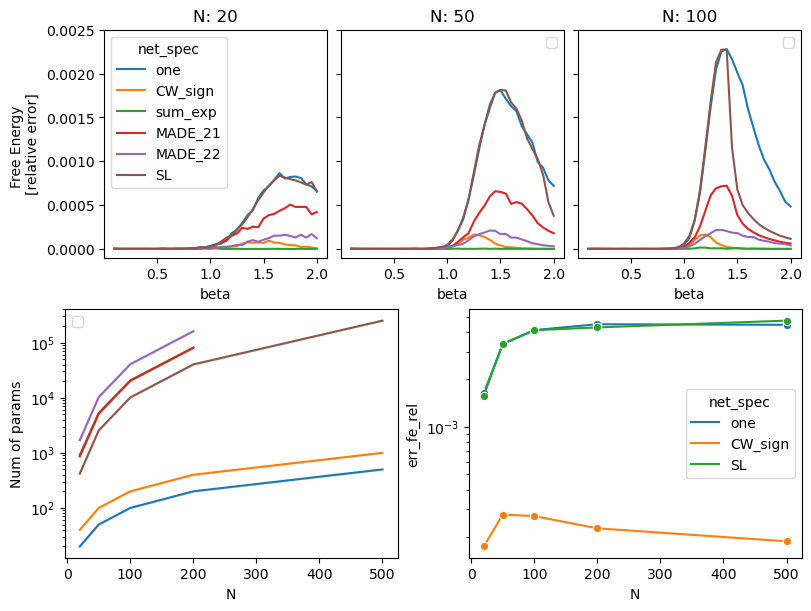

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

data_pl = {}
to_pl = ['one', 'CW_sign', 'sum_exp', 'MADE_21', 'MADE_22', 'SL']
for N in Ns:
    data_pl[N] = data[N][data[N]['net_spec'].isin(to_pl)]    

all_N = pd.DataFrame()
all_N = pd.concat([data_pl[xx] for xx in data_pl])
all_N["N"]=pd.to_numeric(all_N["N"])

fig = plt.figure(constrained_layout=True, figsize=(8, 6))
gs = fig.add_gridspec(2, 1)

gs00 = gs[0].subgridspec(1, 3)
gs01 = gs[1].subgridspec(1, 2)

axs = [[], []]
axs[0].append(fig.add_subplot(gs00[0,0]))
axs[0].append(fig.add_subplot(gs00[0,1]))
axs[0].append(fig.add_subplot(gs00[0,2]))
axs[1].append(fig.add_subplot(gs01[0,0]))
axs[1].append(fig.add_subplot(gs01[0,1]))

# N=10
# #dd = data[N].rolling(5, on="beta").mean()
# sns.lineplot(data=data[N], x="beta", y="err_fe", hue="net_spec", ax=axs[0][0])
N=20
sns.lineplot(data=data_pl[N], x="beta", y="err_fe", hue="net_spec", ax=axs[0][0])
N=50
sns.lineplot(data=data_pl[N], x="beta", y="err_fe", hue="net_spec", ax=axs[0][1])
N=100
sns.lineplot(data=data_pl[N], x="beta", y="err_fe", hue="net_spec", ax=axs[0][2])
axs[0][0].set_ylim(-0.0001, 0.0025)
axs[0][1].set_ylim(-0.0001, 0.0025)
axs[0][2].set_ylim(-0.0001, 0.0025)
axs[0][0].set_title(f"N: 20")
axs[0][1].set_title(f"N: 50")
axs[0][2].set_title(f"N: 100")
axs[0][1].set_yticklabels([])
axs[0][2].set_yticklabels([])
axs[0][2].set_ylabel("")
axs[0][1].set_ylabel("")
axs[0][0].set_ylabel("Free Energy \n[relative error]")
axs[1][0].set_ylabel("Num of params")
sns.lineplot(data=all_N, x="N", y="num_train_params", hue="net_spec", ax=axs[1][0])
axs[0][2].legend("")
axs[0][1].legend("")
axs[1][0].legend("")
data_pl = {}
to_pl = ['one', 'CW_sign', 'SL']
for N in Ns:
    data_pl[N] = data[N][data[N]['net_spec'].isin(to_pl)]    

all_N = pd.DataFrame()
all_N = pd.concat([data_pl[xx] for xx in data_pl])
all_N["N"]=pd.to_numeric(all_N["N"])
sns.lineplot(data=all_N, x="N", y="err_fe_rel", hue="net_spec", ax=axs[1][1], estimator=np.max, errorbar=None, marker="o")

axs[1][0].set_yscale("log")
axs[1][1].set_yscale("log")
#plt.tight_layout()

<AxesSubplot:xlabel='beta', ylabel='err_fe_rel'>

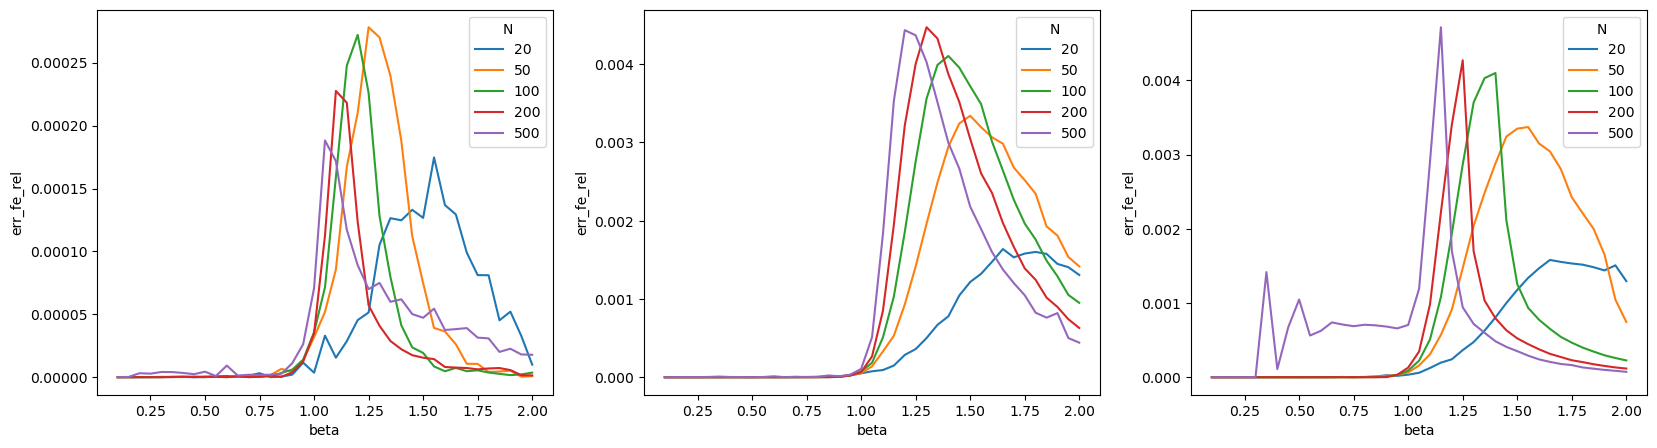

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

data_pl = {}
to_pl = ['one', 'CW_sign', 'SL']
for N in Ns:
    data_pl[N] = data[N][data[N]['net_spec'].isin(to_pl)]    

all_N = pd.DataFrame()
all_N = pd.concat([data_pl[xx] for xx in data_pl])
#fig, axs = plt.subplots(1,3, figsize=(20, 5), sharey=True)
fig, axs = plt.subplots(1,3, figsize=(20, 5))

sns.lineplot(data=all_N[all_N["net_spec"] == 'CW_sign'], x="beta", y="err_fe_rel", hue="N", ax=axs[0])
sns.lineplot(data=all_N[all_N["net_spec"] == 'one'], x="beta", y="err_fe_rel", hue="N", ax=axs[1])
sns.lineplot(data=all_N[all_N["net_spec"] == 'SL'], x="beta", y="err_fe_rel", hue="N", ax=axs[2])


<AxesSubplot:xlabel='beta', ylabel='err_fe_rel'>

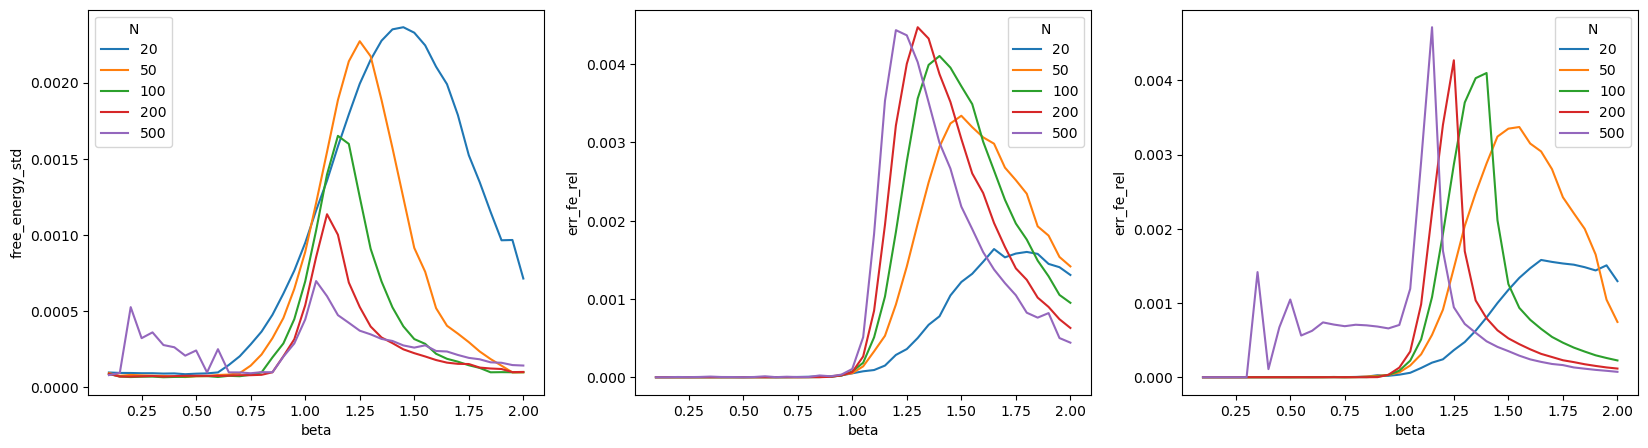

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

data_pl = {}
to_pl = ['one', 'CW_sign', 'SL']
for N in Ns:
    data_pl[N] = data[N][data[N]['net_spec'].isin(to_pl)]    

all_N = pd.DataFrame()
all_N = pd.concat([data_pl[xx] for xx in data_pl])
#fig, axs = plt.subplots(1,3, figsize=(20, 5), sharey=True)
fig, axs = plt.subplots(1,3, figsize=(20, 5))

sns.lineplot(data=all_N[all_N["net_spec"] == 'CW_sign'], x="beta", y="free_energy_std", hue="N", ax=axs[0])
sns.lineplot(data=all_N[all_N["net_spec"] == 'one'], x="beta", y="err_fe_rel", hue="N", ax=axs[1])
sns.lineplot(data=all_N[all_N["net_spec"] == 'SL'], x="beta", y="err_fe_rel", hue="N", ax=axs[2])


In [ ]:
import seaborn as sns
N=20
sns.lineplot(data=data[N], x="beta", y="err_fe_rel", hue="net_spec")

ValueError: Could not interpret value `err_fe_rel` for parameter `y`

<AxesSubplot:xlabel='beta', ylabel='err_fe_rel'>

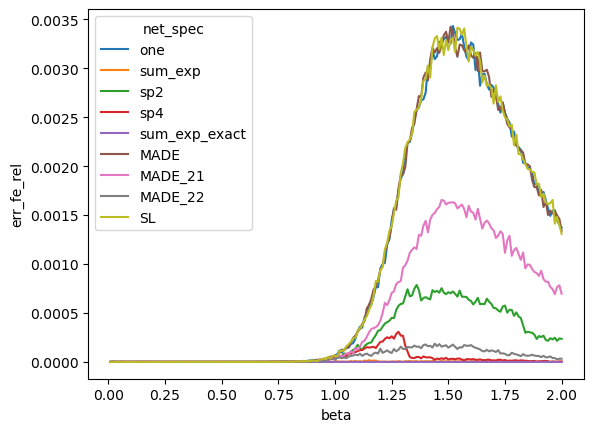

In [ ]:
import seaborn as sns
N=50
sns.lineplot(data=data[N], x="beta", y="err_fe_rel", hue="net_spec")

<AxesSubplot:xlabel='beta', ylabel='err_fe_rel'>

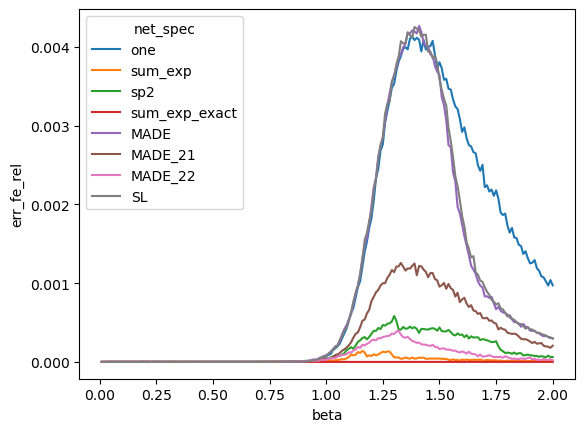

In [ ]:
import seaborn as sns
N=100
sns.lineplot(data=data[N], x="beta", y="err_fe_rel", hue="net_spec")

In [ ]:
data[10]

beta  free_energy  free_energy_std  mag_mean                   save_dir  \
0     0.01   -69.314944         0.000000  0.248303  results/Curie-Weiss/data/   
1     0.02   -34.657814         0.000000  0.249551  results/Curie-Weiss/data/   
2     0.03   -23.105592         0.000000  0.250815  results/Curie-Weiss/data/   
3     0.04   -17.329599         0.000000  0.252093  results/Curie-Weiss/data/   
4     0.05   -13.864099         0.000000  0.253388  results/Curie-Weiss/data/   
...    ...          ...              ...       ...                        ...   
1995  1.96          NaN         0.004807  0.905210  results/Curie-Weiss/data/   
1996  1.97          NaN         0.004841  0.906230  results/Curie-Weiss/data/   
1997  1.98          NaN         0.004791  0.908950  results/Curie-Weiss/data/   
1998  1.99          NaN         0.004764  0.911640  results/Curie-Weiss/data/   
1999  2.00          NaN         0.004838  0.911740  results/Curie-Weiss/data/   

     file_name model net_spec device suffix  ... batch_iter stats_step  \
0         data    CW    exact    cpu   None  ...         20          1   
1         data    CW    exact    cpu   None  ...         20          1   
2         data    CW    exact    cpu   None  ...         20          1   
3         data    CW    exact    cpu   None  ...         20          1   
4         data    CW    exact    cpu   None  ...         20          1   
...        ...   ...      ...    ...    ...  ...        ...        ...   
1995      data    CW       SL    cpu   None  ...         20          1   
1996      data    CW       SL    cpu   None  ...         20          1   
1997      data    CW       SL    cpu   None  ...         20          1   
1998      data    CW       SL    cpu   None  ...         20          1   
1999      data    CW       SL    cpu   None  ...         20          1   

     num_threads          beta_range free_energy_mean entropy_mean  \
0              1  [0.01, 2.0, 200.0]              NaN          NaN   
1              1  [0.01, 2.0, 200.0]              NaN          NaN   
2              1  [0.01, 2.0, 200.0]              NaN          NaN   
3              1  [0.01, 2.0, 200.0]              NaN          NaN   
4              1  [0.01, 2.0, 200.0]              NaN          NaN   
...          ...                 ...              ...          ...   
1995           1  [0.01, 2.0, 200.0]        -0.503581     0.248837   
1996           1  [0.01, 2.0, 200.0]        -0.502903     0.247070   
1997           1  [0.01, 2.0, 200.0]        -0.502332     0.243766   
1998           1  [0.01, 2.0, 200.0]        -0.501678     0.239506   
1999           1  [0.01, 2.0, 200.0]        -0.501082     0.238949   

     energy_mean      mag num_params num_train_params  
0            NaN      NaN        NaN              NaN  
1            NaN      NaN        NaN              NaN  
2            NaN      NaN        NaN              NaN  
3            NaN      NaN        NaN              NaN  
4            NaN      NaN        NaN              NaN  
...          ...      ...        ...              ...  
1995   -0.376623  0.00589      110.0            110.0  
1996   -0.377487 -0.00239      110.0            110.0  
1997   -0.379218 -0.00315      110.0            110.0  
1998   -0.381323 -0.00228      110.0            110.0  
1999   -0.381608  0.00364      110.0            110.0  

[2000 rows x 27 columns]

In [ ]:
N=20
batch_size=2000
std_fe_limit=1e-4
lr=0.001
data[f"CW_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}"] = pd.read_csv(f"data/CW_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}.zip")

N=50
batch_size=2000
std_fe_limit=1e-4
lr=0.001
data[f"CW_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}"] = pd.read_csv(f"data/CW_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}.zip")

N=50
batch_size=2000
std_fe_limit=1e-4
lr=0.0005
data[f"CW_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}"] = pd.read_csv(f"data/CW_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}.zip")

N=100
batch_size=2000
std_fe_limit=1e-4
lr=0.001
data[f"CW_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}"] = pd.read_csv(f"data/CW_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}.zip")


In [ ]:
data.keys()

dict_keys(['CW_N20_bs2000_fe_lim0.0001_lr0.001', 'CW_N50_bs2000_fe_lim0.0001_lr0.001', 'CW_N50_bs2000_fe_lim0.0001_lr0.0005', 'CW_N100_bs2000_fe_lim0.0001_lr0.001'])

<AxesSubplot:xlabel='beta'>

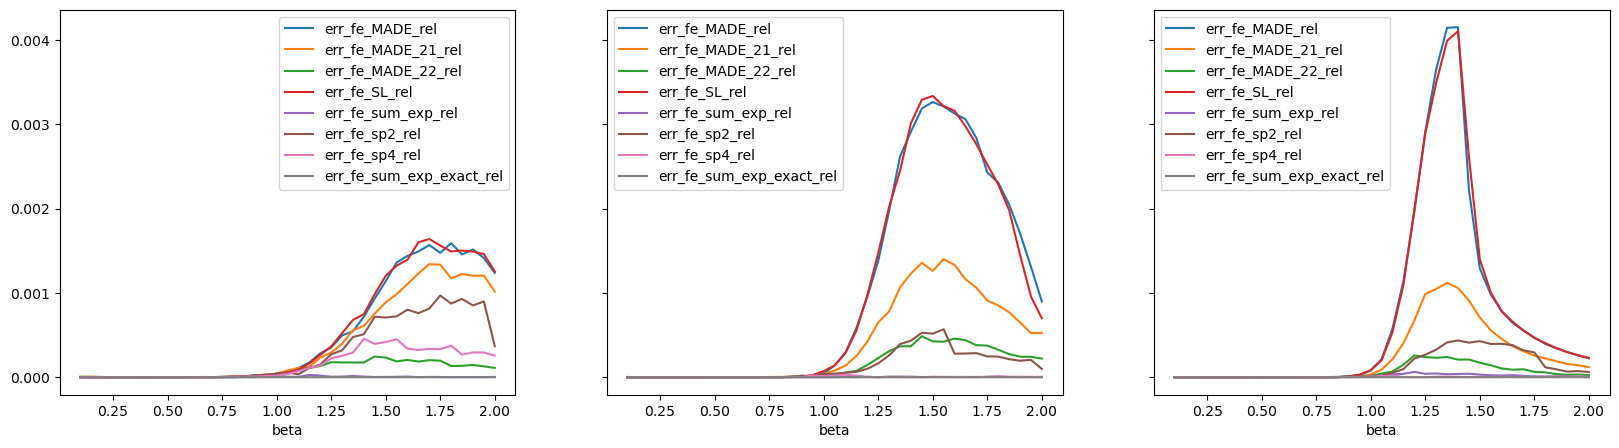

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,3, figsize=(20,5), sharey=True)
data

name_nets=["_MADE", "_MADE_21", "_MADE_22", "_SL", "_sum_exp", "_sp2", "_sp4", "_sum_exp_exact"]
namess=[f"err_fe{x}_rel" for x in name_nets]
#namess.append("free_energy_std")
data['CW_N20_bs2000_fe_lim0.0001_lr0.001'].plot(x="beta", y=namess, ax=axs[0])
data['CW_N50_bs2000_fe_lim0.0001_lr0.001'].plot(x="beta", y=namess, ax=axs[1])
data['CW_N100_bs2000_fe_lim0.0001_lr0.001'].plot(x="beta", y=namess, ax=axs[2])

<AxesSubplot:xlabel='beta'>

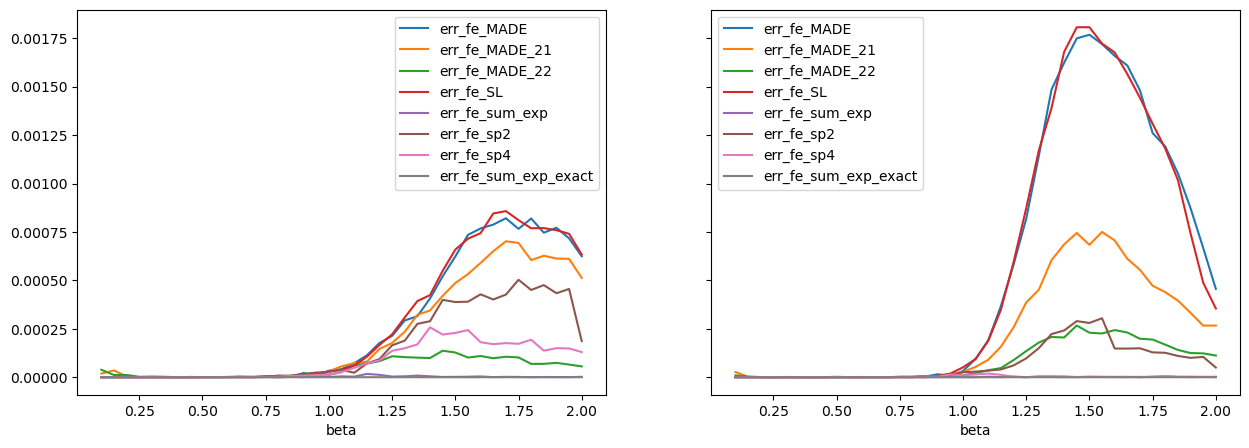

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(15,5), sharey=True)
data

name_nets=["_MADE", "_MADE_21", "_MADE_22", "_SL", "_sum_exp", "_sp2", "_sp4", "_sum_exp_exact"]
namess=[f"err_fe{x}" for x in name_nets]
#namess.append("free_energy_std")
data['CW_N20_bs2000_fe_lim0.0001_lr0.001'].plot(x="beta", y=namess, ax=axs[0])
data['CW_N50_bs2000_fe_lim0.0001_lr0.001'].plot(x="beta", y=namess, ax=axs[1])

# Curie Weiss

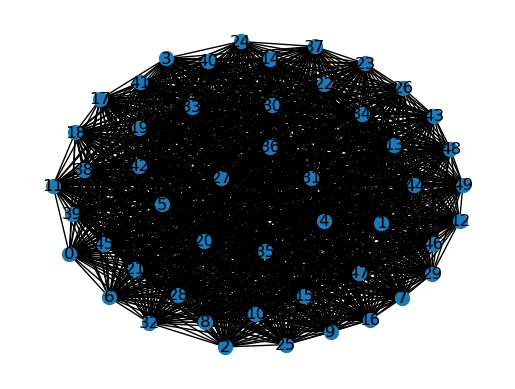

In [ ]:
import importlib
import matplotlib.pyplot as plt

N = 50
fig, ax0 = plt.subplots(1,1)
J_interaction = torch.ones(N,N) - torch.eye(N, N)

inter_H = 0
H = inter_H * (torch.ones(N))

if N < 200:
    graph_gen.plot_matrix_graph(J_interaction, ax0)
JJ=1
J_val = JJ/(2*N)
J = J_val * J_interaction

#N_rand, J_interaction_rand = graph_gen.tree_interaction(Degree, Height, rand=True)

# Exact solutions
enumerating all configurations.
Th. results

In [ ]:
from python_lib.models import spins_model
import python_lib.models
importlib.reload(spins_model)
from python_lib.models import spins_model

device="cpu"
#device="mps"
CW_model = spins_model.model(N, H, J, J_interaction, device=device)
beta_fin=2

beta_init = 0.1
step = 0.05
betas = np.arange(beta_init, beta_fin+step, step)

In [ ]:
from python_lib.models import spins_model
importlib.reload(spins_model)

CW_model_exact = spins_model.KW_exact_fast(N, H, J, J_interaction, device="cpu")
f_exact = []
f_exact_infN = []
for beta_ in betas:
    f_exact.append(CW_model_exact.exact(beta_))
    f_exact_infN.append(CW_model_exact.exact_infN(beta_))

In [ ]:
f_exact_infN[0]

{'beta': 0.1,
 'free_energy': -6.931021827284194,
 'free_energy_std': 0,
 'mag_mean': 0.009999666456504392}

In [ ]:
CW_model_exact.H[0].item()

0.0

In [ ]:
data_exact = pd.DataFrame(f_exact)
f_exact_infN_pd = pd.DataFrame(f_exact_infN)
f_exact_infN_pd = f_exact_infN_pd.add_suffix("_inf")


In [ ]:
data = data_exact
data = pd.concat([data, f_exact_infN_pd], axis = 1)


In [ ]:
data

beta  free_energy  free_energy_std  mag_mean  beta_inf  free_energy_inf  \
0   0.10    -6.931996                0  0.118328      0.10        -6.931022   
1   0.15    -4.621795                0  0.121727      0.15        -4.620344   
2   0.20    -3.466862                0  0.125422      0.20        -3.464936   
3   0.25    -2.774052                0  0.129456      0.25        -2.771651   
4   0.30    -2.312320                0  0.133882      0.30        -2.309441   
5   0.35    -1.982648                0  0.138765      0.35        -1.979284   
6   0.40    -1.735531                0  0.144186      0.40        -1.731669   
7   0.45    -1.543469                0  0.150243      0.45        -1.539090   
8   0.50    -1.389967                0  0.157061      0.50        -1.385045   
9   0.55    -1.264532                0  0.164800      0.55        -1.259031   
10  0.60    -1.160174                0  0.173664      0.60        -1.154046   
11  0.65    -1.072061                0  0.183917      0.65        -1.065244   
12  0.70    -0.996751                0  0.195905      0.70        -0.989161   
13  0.75    -0.931731                0  0.210079      0.75        -0.923259   
14  0.80    -0.875130                0  0.227031      0.80        -0.865633   
15  0.85    -0.825537                0  0.247526      0.85        -0.814828   
16  0.90    -0.781879                0  0.272528      0.90        -0.769710   
17  0.95    -0.743339                0  0.303174      0.95        -0.729385   
18  1.00    -0.709300                0  0.340663      1.00        -0.693139   
19  1.05    -0.679302                0  0.385943      1.05        -0.661824   
20  1.10    -0.653001                0  0.439169      1.10        -0.636215   
21  1.15    -0.630127                0  0.499032      1.15        -0.615143   
22  1.20    -0.610433                0  0.562412      1.20        -0.597706   
23  1.25    -0.593651                0  0.624917      1.25        -0.583200   
24  1.30    -0.579468                0  0.682308      1.30        -0.571075   
25  1.35    -0.567536                0  0.731915      1.35        -0.560896   
26  1.40    -0.557502                0  0.773067      1.40        -0.552316   
27  1.45    -0.549044                0  0.806542      1.45        -0.545057   
28  1.50    -0.541882                0  0.833715      1.50        -0.538894   
29  1.55    -0.535789                0  0.855966      1.55        -0.533646   
30  1.60    -0.530582                0  0.874427      1.60        -0.529164   
31  1.65    -0.526113                0  0.889946      1.65        -0.525326   
32  1.70    -0.522261                0  0.903142      1.70        -0.522030   
33  1.75    -0.518932                0  0.914465      1.75        -0.519194   
34  1.80    -0.516043                0  0.924252      1.80        -0.516748   
35  1.85    -0.513530                0  0.932761      1.85        -0.514634   
36  1.90    -0.511338                0  0.940193      1.90        -0.512803   
37  1.95    -0.509420                0  0.946710      1.95        -0.511215   
38  2.00    -0.507739                0  0.952442      2.00        -0.509836   

    free_energy_std_inf  mag_mean_inf  
0                     0      0.010000  
1                     0      0.014999  
2                     0      0.019997  
3                     0      0.024995  
4                     0      0.029991  
5                     0      0.034986  
6                     0      0.039979  
7                     0      0.044970  
8                     0      0.049958  
9                     0      0.054945  
10                    0      0.059928  
11                    0      0.064909  
12                    0      0.069886  
13                    0      0.074860  
14                    0      0.079830  
15                    0      0.084796  
16                    0      0.089758  
17                    0      0.094715  
18                    0      0.099668  
19                    0      0.370696  
20 

In [ ]:
data.dtypes

beta                   float64
free_energy            float64
free_energy_std          int64
mag_mean               float64
beta_inf               float64
free_energy_inf        float64
free_energy_std_inf      int64
mag_mean_inf           float64
dtype: object

<AxesSubplot:xlabel='beta'>

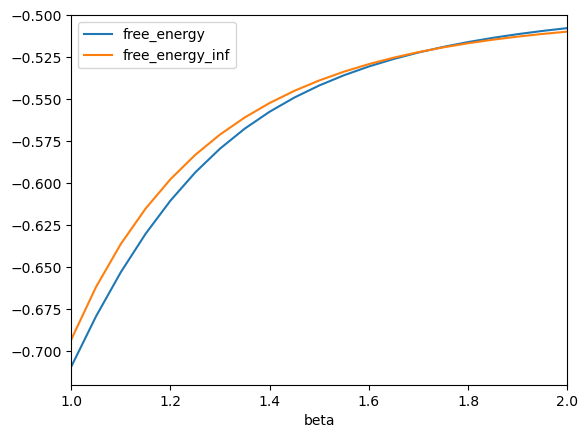

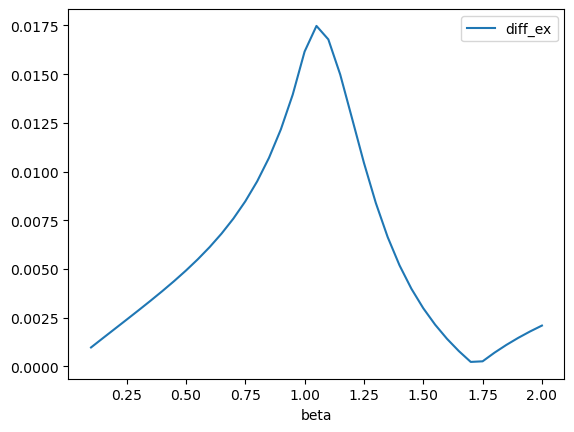

In [ ]:
data.plot(x="beta", y= ["free_energy", "free_energy_inf"], ylim=[-0.72,-0.5], xlim=[1,2])
data["diff_ex"] = np.abs(data["free_energy"]- data[ "free_energy_inf"])
data.plot(x="beta", y= "diff_ex")


# Several cases

In [ ]:
lr = 0.001
max_step=1000
batch_size=2000
std_fe_limit=1e-4
batch_iter=20

In [ ]:
from python_lib.nets import list_nets
importlib.reload(list_nets)
import python_lib.nets.ann
importlib.reload(python_lib.nets.ann)
from python_lib import run_lib
importlib.reload(run_lib);

In [ ]:
from python_lib.nets import made
import importlib
importlib.reload(made);

net2train = made.MADE(CW_model, bias=True, device=device)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_MADE",
    batch_iter=batch_iter
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 2550
Total Params: 2550
step: 0 2.00 fe: -0.507 +- 0.00335 E: -0.447, S: 0.121, M: 0.954953

In [ ]:
from python_lib.nets import made
import importlib
importlib.reload(made);

net2train = made.MADE(CW_model, 
    bias=True, 
    device=device,
    net_depth=2,
    net_width=1
)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_MADE_21",
    batch_iter=batch_iter,
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 5150
Total Params: 5150
step: 0 2.00 fe: -0.508 +- 0.00172 E: -0.446, S: 0.123, M: 0.954953

In [ ]:
from python_lib.nets import made
import importlib
importlib.reload(made);

net2train = made.MADE(CW_model, 
    bias=True, 
    device=device,
    net_depth=2,
    net_width=2
)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_MADE_22",
    batch_iter=batch_iter,
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 10250
Total Params: 10250
step: 0 2.00 fe: -0.508 +- 0.00166 E: -0.444, S: 0.128, M: 0.951952

In [ ]:
from python_lib.nets import simple_layer
import importlib
importlib.reload(simple_layer)
net2train = simple_layer.simple_layer(CW_model, bias=True, device=device)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_SL",
    batch_iter=batch_iter
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 2550
Total Params: 2550
step: 0 2.00 fe: -0.507 +- 0.00188 E: -0.448, S: 0.118, M: 0.956954

In [ ]:
# from python_lib.nets import ann
# importlib.reload(ann)

# from python_lib.nets import list_nets
# importlib.reload(list_nets)

# one = list_nets.one_var
# input_mask = torch.tril(J_interaction, diagonal=-1)
# input_mask = input_mask.to(dtype=torch.bool)
# dict_nets = {}
# net2train = list_nets.list_nets(CW_model, one, input_mask, device=device, dict_nets=dict_nets)
# res = run_lib.train_net(net2train, betas,
#     lr = lr,
#     max_step=max_step,
#     batch_size=batch_size,
#     std_fe_limit=std_fe_limit,
#     suffix ="_one",
#     batch_iter=batch_iter
# )
# data = pd.concat([data, res], axis = 1)


In [ ]:
from python_lib.nets import list_nets
importlib.reload(list_nets)

list_n = list_nets.CW_net
input_mask = torch.tril(J_interaction, diagonal=-1)
input_mask = input_mask.to(dtype=torch.bool)
dict_nets = {}
net2train = list_nets.list_nets(CW_model, list_n, input_mask, device=device, dict_nets=dict_nets)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_sum_exp_exact",
    exact=True,
    batch_iter=batch_iter
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 5294
Total Params: 5294
step: 0 2.00 fe: -0.508 +- 0.00000 E: -0.445, S: 0.125, M: 0.953

In [ ]:
from python_lib.nets import list_nets
importlib.reload(list_nets)

list_n = list_nets.CW_net
input_mask = torch.tril(J_interaction, diagonal=-1)
input_mask = input_mask.to(dtype=torch.bool)
dict_nets = {}
net2train = list_nets.list_nets(CW_model, list_n, input_mask, device=device, dict_nets=dict_nets)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_sum_exp",
    batch_iter=batch_iter
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 5294
Total Params: 5294
step: 0 2.00 fe: -0.508 +- 0.00021 E: -0.445, S: 0.126, M: 0.952538

In [ ]:
# from python_lib.nets import list_nets
# importlib.reload(list_nets)

# list_n = list_nets.CW_net_sp
# input_mask = torch.tril(J_interaction, diagonal=-1)
# input_mask = input_mask.to(dtype=torch.bool)
# dict_nets = {"num_extremes": 1}
# net2train = list_nets.list_nets(CW_model, list_n, input_mask, device=device, dict_nets=dict_nets)
# res = run_lib.train_net(net2train, betas,
#     lr = lr,
#     max_step=max_step,
#     batch_size=batch_size,
#     std_fe_limit=std_fe_limit,
#     suffix ="_sp",
#     batch_iter=batch_iter
# )
# data = pd.concat([data, res], axis = 1)


In [ ]:
from python_lib.nets import list_nets
importlib.reload(list_nets)

list_n = list_nets.CW_net_sp
input_mask = torch.tril(J_interaction, diagonal=-1)
input_mask = input_mask.to(dtype=torch.bool)
dict_nets = {"num_extremes": 2}
net2train = list_nets.list_nets(CW_model, list_n, input_mask, device=device, dict_nets=dict_nets)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_sp2",
    batch_iter=batch_iter
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 982
Total Params: 982
step: 0 2.00 fe: -0.508 +- 0.00111 E: -0.445, S: 0.126, M: 0.953953

In [ ]:
from python_lib.nets import list_nets
importlib.reload(list_nets)

list_n = list_nets.CW_net_sp
input_mask = torch.tril(J_interaction, diagonal=-1)
input_mask = input_mask.to(dtype=torch.bool)
dict_nets = {"num_extremes": 4}
net2train = list_nets.list_nets(CW_model, list_n, input_mask, device=device, dict_nets=dict_nets)
res = run_lib.train_net(net2train, betas,
    lr = lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit=std_fe_limit,
    suffix ="_sp4",
    batch_iter=batch_iter
)
data = pd.concat([data, res], axis = 1)


Total Trainable Params: 1766
Total Params: 1766
step: 0 2.00 fe: -0.508 +- 0.00040 E: -0.445, S: 0.125, M: 0.953532

In [ ]:
data["beta"] = betas

In [ ]:
name_nets=["_MADE", "_MADE_21", "_MADE_22", "_SL", "_sum_exp", "_sp2", "_sp4", "_sum_exp_exact"]

for kk in name_nets:
    data[f"err_fe{kk}"] = np.abs(data[f"free_energy_mean{kk}"] - data["free_energy"])
    data[f"err_fe{kk}_rel"] = np.abs((data[f"err_fe{kk}"] / data["free_energy"]))


In [ ]:
data.to_csv(f"data/CW_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}.zip")

In [ ]:
data.read.csv(f"data/CW_N{N}_bs{batch_size}_fe_lim{std_fe_limit}_lr{lr}.zip")

<AxesSubplot:xlabel='beta'>

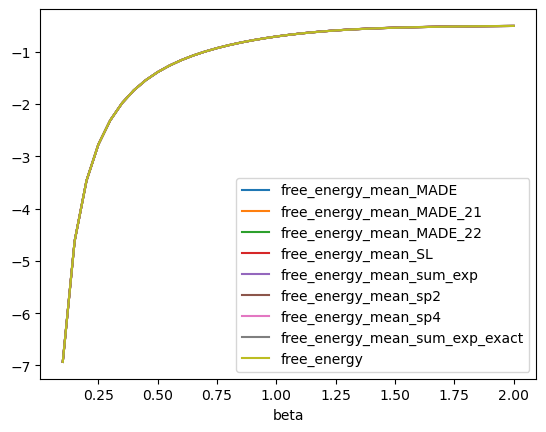

In [ ]:
name_nets=["_MADE", "_MADE_21", "_MADE_22", "_SL", "_sum_exp", "_sp2", "_sp4", "_sum_exp_exact"]
kkk="free_energy_mean"
namess=[f"{kkk}{x}" for x in name_nets]
namess.append("free_energy")
data.plot(x="beta", y=namess)


<AxesSubplot:xlabel='beta'>

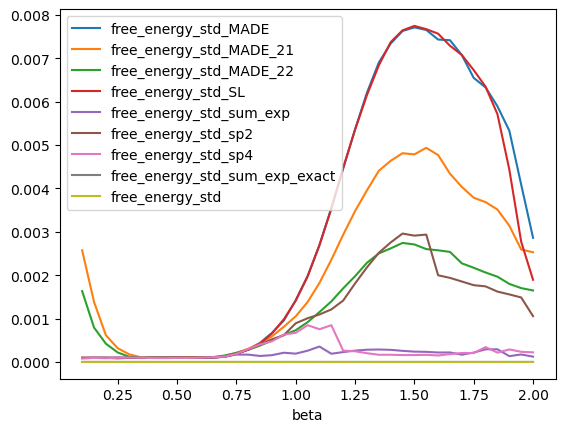

In [ ]:
name_nets=["_MADE", "_MADE_21", "_MADE_22", "_SL", "_sum_exp", "_sp2", "_sp4", "_sum_exp_exact"]
kkk="free_energy_std"
namess=[f"{kkk}{x}" for x in name_nets]
namess.append("free_energy_std")
data.plot(x="beta", y=namess)

<AxesSubplot:xlabel='beta'>

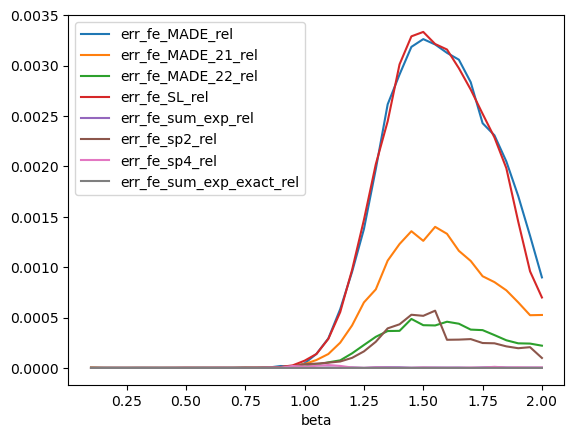

In [ ]:
name_nets=["_MADE", "_MADE_21", "_MADE_22", "_SL", "_sum_exp", "_sp2", "_sp4", "_sum_exp_exact"]
namess=[f"err_fe{x}_rel" for x in name_nets]
#namess.append("free_energy_std")
data.plot(x="beta", y=namess)

<AxesSubplot:xlabel='beta'>

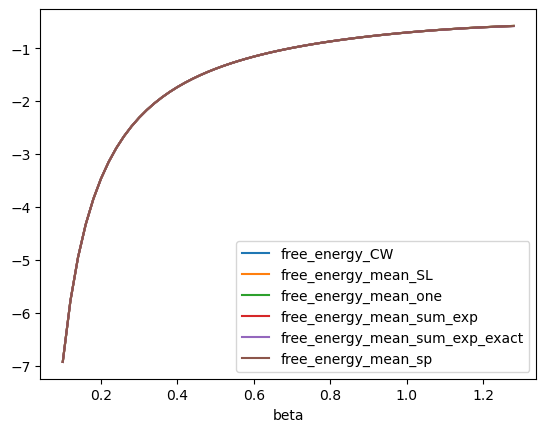

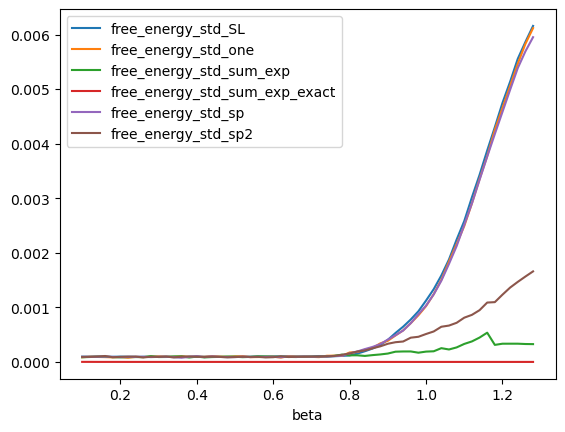

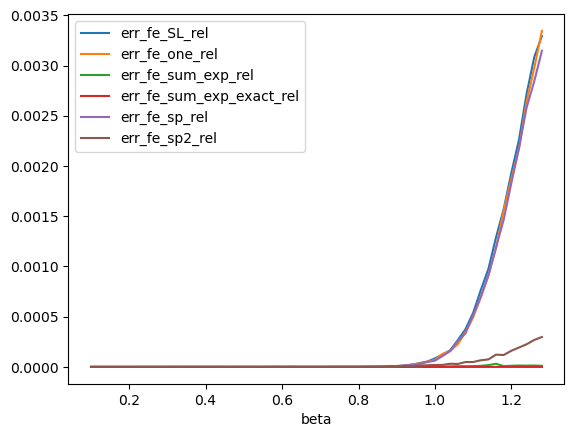

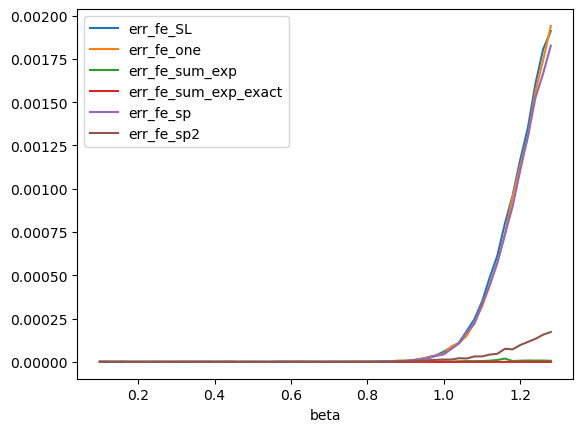

In [ ]:

data.plot(x="beta", y=["free_energy_std_SL", "free_energy_std_one", "free_energy_std_sum_exp", "free_energy_std_sum_exp_exact","free_energy_std_sp","free_energy_std_sp2",]) #"free_energy_std_sp4"])
data.plot(x="beta", y=["err_fe_SL_rel", "err_fe_one_rel", "err_fe_sum_exp_rel", "err_fe_sum_exp_exact_rel","err_fe_sp_rel","err_fe_sp2_rel"])#,"err_fe_sp4_rel"])
data.plot(x="beta", y=["err_fe_SL", "err_fe_one", "err_fe_sum_exp", "err_fe_sum_exp_exact", "err_fe_sp", "err_fe_sp2"])# "err_fe_sp4"])

In [ ]:
data.plot(x="beta", y=["mag_mean", "mag_mean_CW", "mag_mean_SL", "mag_mean_one", "mag_mean_sum_exp", "mag_mean_sum_exp_exact"])


KeyError: "['mag_mean'] not in index"

In [ ]:
data.plot(x="beta", y=["entropy_mean", "entropy_mean_SL", "entropy_mean_1V", "entropy_mean_SK", "entropy_mean_SK_exact"])


KeyError: "['entropy_mean', 'entropy_mean_1V', 'entropy_mean_SK', 'entropy_mean_SK_exact'] not in index"

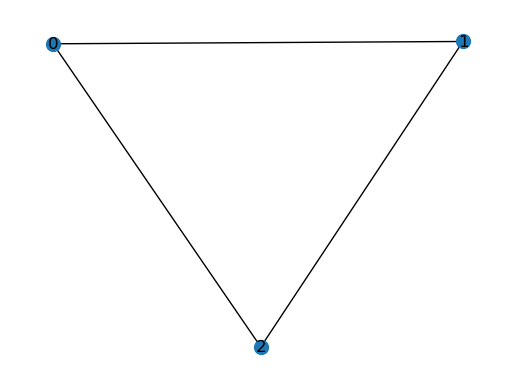

In [ ]:
from python_lib.models import spins_model
import python_lib.models
importlib.reload(spins_model)
from python_lib.models import spins_model

N = 3
fig, ax0 = plt.subplots(1,1)
J_interaction = torch.ones(N,N) - torch.eye(N, N)

inter_H = 0
H = inter_H * (torch.ones(N))

if N < 200:
    graph_gen.plot_matrix_graph(J_interaction, ax0)
JJ=1
J_val = JJ/(2*N)
J = J_val * J_interaction


device="cpu"
#device="mps"
CW_model = spins_model.model(N, H, J, J_interaction, device=device)
beta_fin=1.3
beta_init = 0.1
step = 0.1
betas = np.arange(beta_init, beta_fin
, step)

In [ ]:
from python_lib.nets import ann
importlib.reload(ann)
from python_lib.nets import list_nets
importlib.reload(list_nets)

one = list_nets.SK_net
input_mask = torch.tril(J_interaction, diagonal=-1)
input_mask = input_mask.long()
dict_nets = {}
net2train = list_nets.list_nets(CW_model, one, input_mask, device=device, dict_nets=dict_nets)

In [ ]:
beta = 1
net2train.train(
    beta=beta,
    lr=lr,
    max_step=max_step,
    batch_size=batch_size,
    std_fe_limit = 0.001,
    exact=True
)


step: 0 1.00 fe: -0.594 +- 0.24724 E: 0.069, S: 0.662, M: 0.397

{'beta': 1,
 'free_energy_mean': -0.5935537020365397,
 'free_energy_std': 0.2472420334815979,
 'entropy_mean': 0.6624425649642944,
 'energy_mean': 0.06888888776302338,
 'mag': array([ 0.001, -0.008,  0.034], dtype=float32),
 'mag_mean': 0.3966667056083679}

In [ ]:
x, hx=net2train.sample(200000)
torch.abs(x.mean(-1)).mean(), x.mean(-1).mean()

(tensor(0.3982), tensor(0.0010))

In [ ]:
i = 0
for nnet in net2train.net:
    print(f"ni: {i}")
    i+=1
    for name, param in nnet.named_parameters():
        print(name, param.data)


ni: 0
weight_p tensor([[ 0.3333,  0.0000, -0.3333]])
bias_p tensor([[1.0000, 0.6931, 0.3333]])
weight_m tensor([[ 0.3333,  0.0000, -0.3333]])
bias_m tensor([[0.3333, 0.6931, 1.0000]])
weight_0p tensor([1.])
weight_0m tensor([-1.])
weight_0 tensor([-0.3333])
bias_0 tensor([-0.])
ni: 1
weight_p tensor([[ 0.1667, -0.1667]])
bias_p tensor([[0.3333, 0.0000]])
weight_m tensor([[ 0.1667, -0.1667]])
bias_m tensor([[0.0000, 0.3333]])
weight_0p tensor([1.])
weight_0m tensor([-1.])
weight_0 tensor([-0.3333])
bias_0 tensor([-0.])
ni: 2
weight_0 tensor([-0.3333])
bias_0 tensor([-0.])


In [ ]:
m = x.sum(-1)
m

tensor([ 2., -6.])

In [ ]:
weight_p = torch.tensor([[1,2,3,4]], device=device)

In [ ]:
weight_p

tensor([[1, 2, 3, 4]])

In [ ]:
res = weight_p * torch.unsqueeze(m, dim=1)
res

tensor([[  2.,   4.,   6.,   8.],
        [ -6., -12., -18., -24.]])

In [ ]:
torch.logsumexp(res, 1)

tensor([ 8.1451, -5.9975])

In [ ]:
pd.__version__

In [ ]:
data.plot(x="beta", y=["free_energy_std_SL", "free_energy_std_1V"], ylim=(0, 0.1))

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
stats_pd.plot.line(x="beta", y="energy_mean")

In [ ]:
stats_pd.plot.line(x="beta", y="energy_mean")

In [ ]:
all_Js = np.array(all_Js)

In [ ]:
plt.plot(stats_pd["beta"], all_Js[:,2])
plt.plot(stats_pd["beta"], all_Js[:,3])
plt.plot(stats_pd["beta"], all_Js[:,4])
plt.plot(stats_pd["beta"], all_Js[:,5])
plt.plot(stats_pd["beta"], all_Js[:,19])

In [ ]:
import pandas as pd

lr = 0.001
max_step=1000
batch_size=1000
stats = []
net2train = net
for beta in betas:
    net2train.train(
        beta=beta,
        lr=lr,
        max_step=max_step,
        batch_size=batch_size,
        std_fe_limit = 0.001
    )

    stats.append(net.compute_stats(
        beta, batch_size=batch_size, print_=True))
stats_pd = pd.DataFrame(stats)

In [ ]:
from python_lib.nets import simplest
from python_lib.solvers import train_nn_anneal
importlib.reload(simplest)
importlib.reload(solvers)
bias = True
net_simplest = simplest.simplest(CW_model.N, CW_model, bias, device=device)

In [ ]:
from python_lib.nets import one_var
importlib.reload(one_var)
bias = True
net_one_var = one_var.one_var(CW_model.N, CW_model, bias, device=device)

In [ ]:
from python_lib.solvers import train_nn_anneal
importlib.reload(simple_layer)
importlib.reload(solvers)
import pandas as pd

lr = 0.001
max_step=1000
batch_size=1000
stats = []
net2train = net_one_var
for beta in betas:
    net2train.train(
        beta=beta,
        lr=lr,
        max_step=max_step,
        batch_size=batch_size,
        std_fe_limit = 0.001
    )

    stats.append(net.compute_stats(
        beta, batch_size=batch_size, print_=True))
stats_pd = pd.DataFrame(stats)

In [ ]:
stats_pd_est = pd.DataFrame(stats)
import matplotlib.pyplot as plt
fig, (ax0, ax1, ax2) = plt.subplots(3,1)
ax0.plot(betas, stats_pd_est["free_energy_mean"], ".")
ax0.plot(betas, f_exact)
ax0.set_ylim(-1.25,0.)

ax1.plot(betas, np.abs(f_exact-stats_pd_est["free_energy_mean"])/np.abs(f_exact))
ax1.plot(betas, np.abs(f_exact-stats_pd_est["free_energy_mean"]))
    
ax2.plot(stats_pd_est["free_energy_std"])

In [ ]:
net_simplest.layer1.weight

In [ ]:
from python_lib.solvers import train_nn_anneal
importlib.reload(simple_layer)
importlib.reload(solvers)
import pandas as pd

lr = 0.001
max_step=100
batch_size=2000
stats = train_nn_anneal(
    net, 
    np.full(100, 0.0001),
    lr=lr, 
    max_step=5,
    batch_size=batch_size)
stats = train_nn_anneal(
    net, 
    betas,
    lr=lr, 
    max_step=max_step,
    batch_size=batch_size)
stats_pd = pd.DataFrame(stats)

In [ ]:
stats_pd = pd.DataFrame(stats)

In [ ]:
import matplotlib.pyplot as plt
fig, (ax0, ax1, ax2) = plt.subplots(3,1)
ax0.plot(betas, stats_pd["free_energy_mean"], ".")
ax0.plot(betas, f_exact)
ax0.set_ylim(-1.25,-0.6)

ax1.plot(betas, np.abs(f_exact-stats_pd["free_energy_mean"])/np.abs(f_exact))
    
ax2.plot(stats_pd["free_energy_std"])

In [ ]:
import matplotlib.pyplot as plt
fig, (ax0, ax1, ax2) = plt.subplots(3,1)
ax0.plot(betas, stats_pd["free_energy_mean"], ".")
ax0.plot(betas, f_exact)
ax0.set_ylim(-1.25,-0.6)

ax1.plot(betas, np.abs(f_exact-stats_pd["free_energy_mean"]))
    
ax2.plot(stats_pd["free_energy_std"])

In [ ]:
stats_pd.keys()

In [ ]:
stats_pd[stats_pd["beta"]==0.2]

In [ ]:
import matplotlib.pyplot as plt
fig, (ax0, ax1) = plt.subplots(2,1)
ax0.plot(betas, stats_pd["free_energy_mean"], ".")
ax0.plot(np.linspace(0.001,beta,100), f_exact)
ax0.set_ylim(-1.25,-0.7)

for b in np.linspace(0.001,beta,100):
    
err = [np.abs()]

In [ ]:
net.compute_stats(beta, batch_size=50000)

## random case

In [ ]:
from python_lib.nets import bp_nn
importlib.reload(bp_nn)

net_rand = bp_nn.bp_nn(tree_rand.N, tree_rand, True, z2=False, init_zero=False,)
                      
net_rand.train(beta=beta, lr=0.001, 
           max_step=1000,
               opt="adam")


In [ ]:
net_rand.compute_stat_is(beta, batch_size=10000)

# BP solution

In [ ]:
import bp_solver
importlib.reload(bp_solver)

bp_sol = bp_solver.BP_solver(tree_rand)

In [ ]:
beta

In [ ]:
bp_sol.converge(beta)